<a href="https://colab.research.google.com/github/varamba/Ya_practicum_projects/blob/main/project_bi_stats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Введение
В данном проекте необходимо проанализировать расходы рекламных компаний фирмы Procrastinate Pro+. Фирмавносит огромные вложения в рекламу, но последние несколько месяцев компания терпит убытки. Задача — разобраться в причинах и помочь компании выйти в плюс.

### Загрузите данные и подготовьте их к анализу

Загрузите данные о визитах, заказах и рекламных расходах из CSV-файлов в переменные.

**Пути к файлам**

- визиты: `/datasets/visits_info_short.csv`.
- заказы: `/datasets/orders_info_short.csv`.
- расходы: `/datasets/costs_info_short.csv`.

Изучите данные и выполните предобработку. Есть ли в данных пропуски и дубликаты? Убедитесь, что типы данных во всех колонках соответствуют сохранённым в них значениям. Обратите внимание на столбцы с датой и временем.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings("ignore")

In [2]:
visits, orders, costs = (
    pd.read_csv('https://code.s3.yandex.net/datasets/visits_info_short.csv'),
    pd.read_csv('https://code.s3.yandex.net/datasets/orders_info_short.csv'),
    pd.read_csv('https://code.s3.yandex.net/datasets/costs_info_short.csv'))

Посмотрим таблицы

In [3]:
display(visits.head())
display(orders.head())
display(costs.head())

User Id         Region   Device  Channel        Session Start  \
0  981449118918  United States   iPhone  organic  2019-05-01 02:36:01   
1  278965908054  United States   iPhone  organic  2019-05-01 04:46:31   
2  590706206550  United States      Mac  organic  2019-05-01 14:09:25   
3  326433527971  United States  Android   TipTop  2019-05-01 00:29:59   
4  349773784594  United States      Mac  organic  2019-05-01 03:33:35   

           Session End  
0  2019-05-01 02:45:01  
1  2019-05-01 04:47:35  
2  2019-05-01 15:32:08  
3  2019-05-01 00:54:25  
4  2019-05-01 03:57:40

User Id             Event Dt  Revenue
0  188246423999  2019-05-01 23:09:52     4.99
1  174361394180  2019-05-01 12:24:04     4.99
2  529610067795  2019-05-01 11:34:04     4.99
3  319939546352  2019-05-01 15:34:40     4.99
4  366000285810  2019-05-01 13:59:51     4.99

dt   Channel  costs
0  2019-05-01  FaceBoom  113.3
1  2019-05-02  FaceBoom   78.1
2  2019-05-03  FaceBoom   85.8
3  2019-05-04  FaceBoom  136.4
4  2019-05-05  FaceBoom  122.1

Приведем столбцы в нормальный вид.

In [4]:
visits.rename(columns={'User Id': 'user_id', 'Session Start': 'Session_Start', 'Session End':'session_end'}, inplace=True)
orders.rename(columns={'User Id': 'user_id', 'Event Dt': 'event_dt'}, inplace=True)
visits.columns= visits.columns.str.lower()
orders.columns= orders.columns.str.lower()
costs.columns= costs.columns.str.lower()

Поменяем тип дат.

In [5]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

In [6]:
display(visits.info())
display(orders.info())
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [7]:
display(visits.duplicated().sum())
display(orders.duplicated().sum())
display(costs.duplicated().sum())

0

0

0

Пропусков и дупликатов нет, можно ехать дальше.

### Задим функции для расчёта и анализа LTV, ROI, удержания и конверсии.

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.
- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

Ну погнали!

In [8]:
def get_profiles(sessions, orders, costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())
    
    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    costs = costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    costs['acquisition_cost'] = costs['costs'] / costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [9]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [10]:

# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [11]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

In [12]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [13]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [14]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(20, 10))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [15]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(25, 15))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### Исследовательский анализ данных

- Составьте профили пользователей. Определите минимальную и максимальную даты привлечения пользователей.
- Выясните, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих из каждой страны.
- Узнайте, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
- Изучите рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

После каждого пункта сформулируйте выводы.

#### Профили пользователей

Создадим профили пользователей.

In [16]:
profiles = get_profiles(visits, orders, costs)
profiles.head()

user_id            first_ts     channel  device         region  \
0    599326 2019-05-07 20:58:57    FaceBoom     Mac  United States   
1   4919697 2019-07-09 12:46:07    FaceBoom  iPhone  United States   
2   6085896 2019-10-01 09:58:33     organic  iPhone         France   
3  22593348 2019-08-22 21:35:48  AdNonSense      PC        Germany   
4  31989216 2019-10-02 00:07:44     YRabbit  iPhone  United States   

           dt               month  payer  acquisition_cost  
0  2019-05-07 2019-05-07 20:58:57   True          1.088172  
1  2019-07-09 2019-07-09 12:46:07  False          1.107237  
2  2019-10-01 2019-10-01 09:58:33  False          0.000000  
3  2019-08-22 2019-08-22 21:35:48  False          0.988235  
4  2019-10-02 2019-10-02 00:07:44  False          0.230769

Установим момент и горизонт анализа данных.

In [17]:
display(profiles['dt'].max())
profiles['dt'].min()

datetime.date(2019, 10, 27)

datetime.date(2019, 5, 1)

Данные совпадают с тз: минимальная дата - 1 мая, максимальная 27 октября.

In [18]:
observation_date = datetime(2019, 11, 1).date()
horizon_days = 14

Согласно ТЗ, считаем, что на дворе 1 ноября 2019 года, при этом реклама должна окупиться за 2 недели.

#### Разбивка по регионам

In [19]:
result_raw, result_grouped, result_in_time = get_conversion(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=['region'],
    ignore_horizon=False)

In [20]:
res_region = result_raw.groupby('region').agg(user_total = ('payer', 'count'), payer=('payer', 'sum'))
res_region['payer_fraction'] = (res_region['payer']/res_region['user_total']*100).round(2)
display(res_region.sort_values(by = 'payer_fraction', ascending = False))

user_total  payer  payer_fraction
region                                          
United States       95042   6549            6.89
Germany             14244    584            4.10
UK                  16710    659            3.94
France              16624    628            3.78

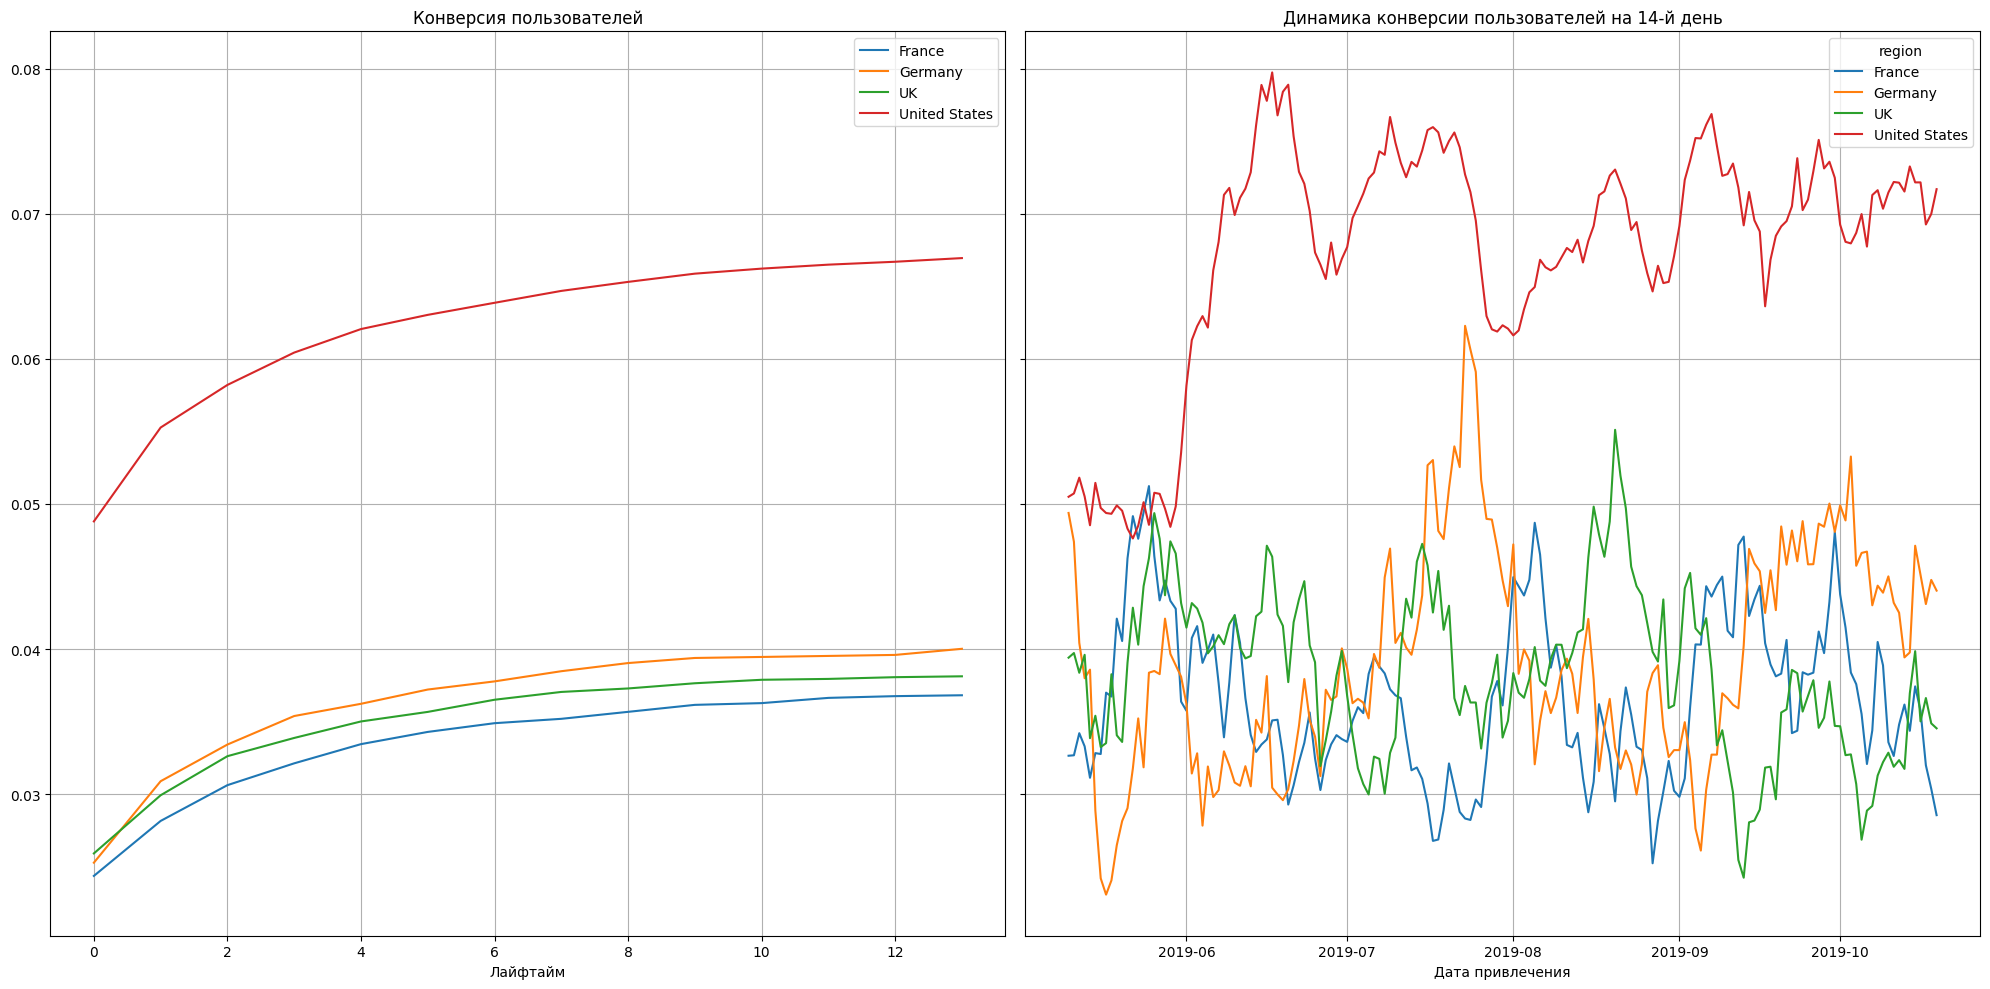

In [21]:
plot_conversion(result_grouped, result_in_time, horizon_days, window=10)

По данным идим, что больше всего людей находится в США - 95042, причем там людей больше чем всех остальных вместе взятых.
Конверсия также самая большая в США - 6,6% к 14 дню.

#### Разбивка по устройствам

In [22]:
result_raw, result_grouped, result_in_time = get_conversion(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=['device'],
    ignore_horizon=False)

In [23]:
res_device = result_raw.groupby('device').agg(user_total = ('payer', 'count'), payer=('payer', 'sum'))
res_device['payer_fraction'] = (res_device['payer']/res_device['user_total']*100).round(2)
display(res_device.sort_values(by = 'payer_fraction', ascending = False))

user_total  payer  payer_fraction
device                                    
Mac           28588   1826            6.39
iPhone        51766   3201            6.18
Android       33288   1954            5.87
PC            28978   1439            4.97

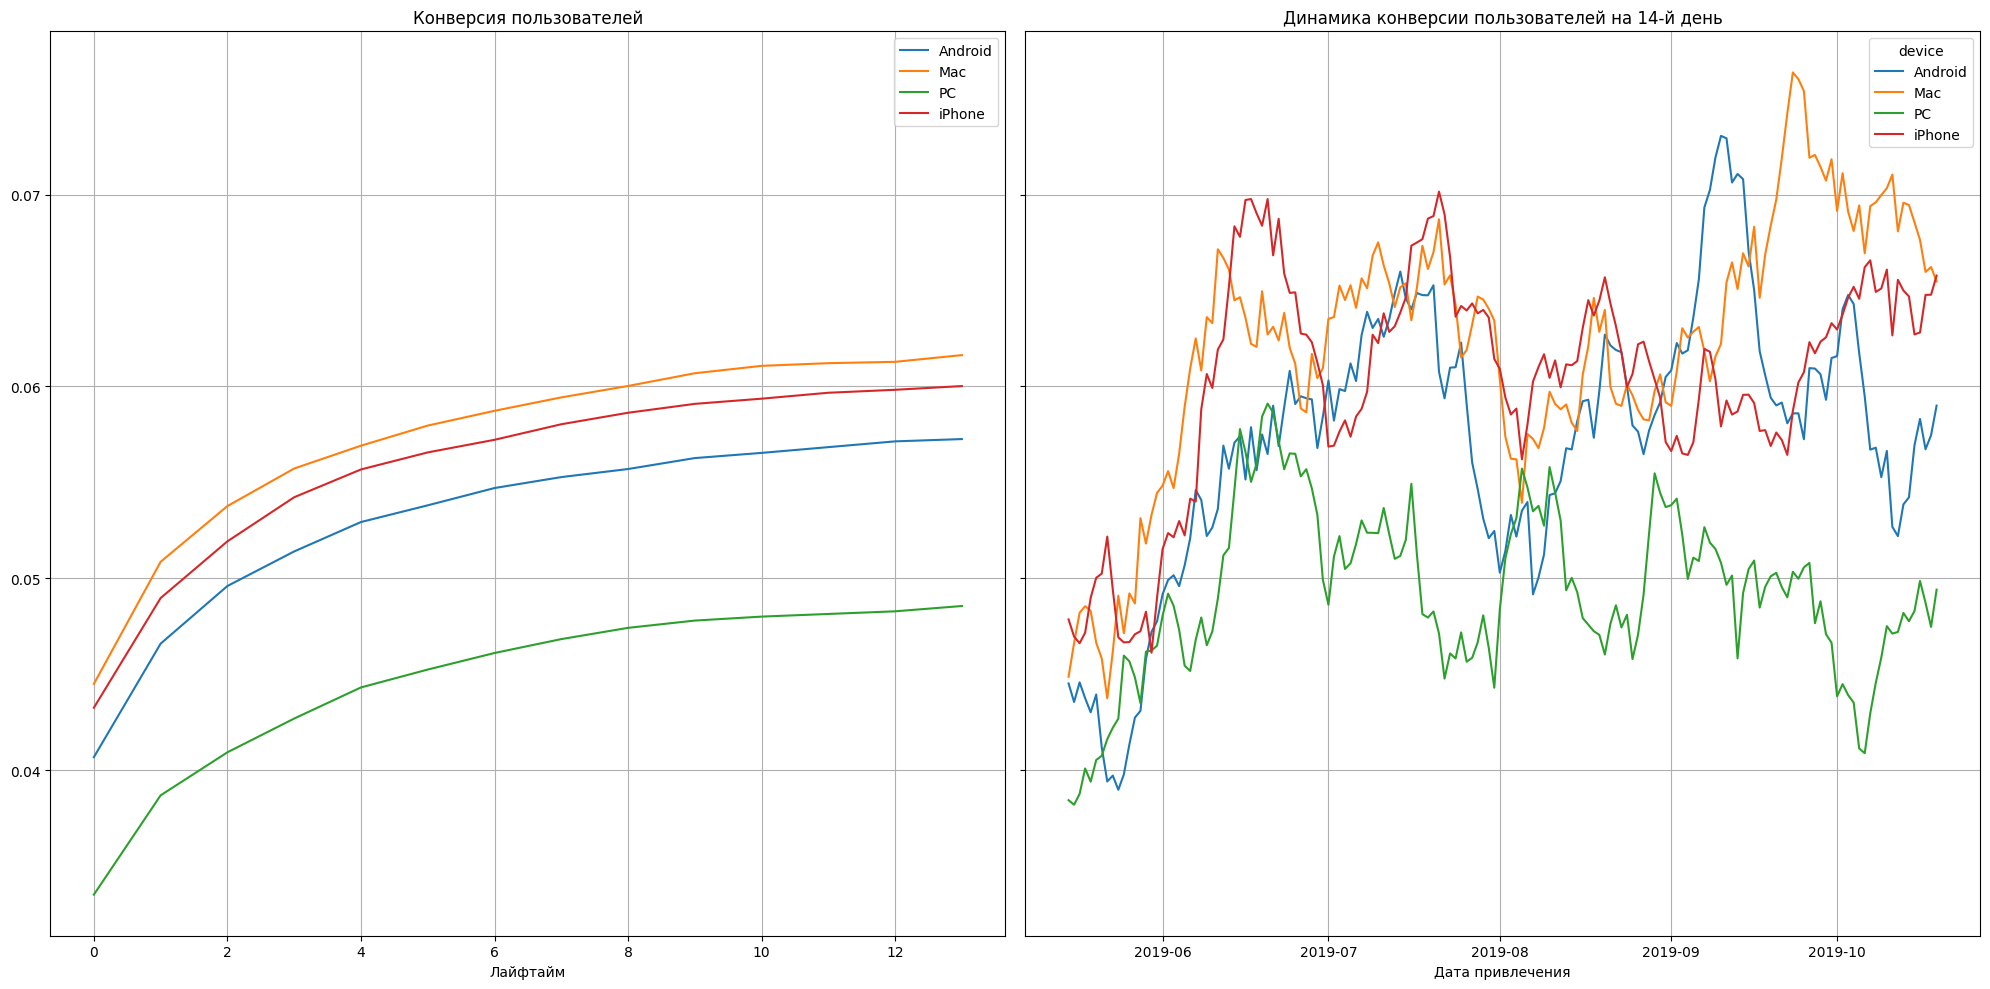

In [24]:
plot_conversion(result_grouped, result_in_time, horizon_days, window=15)

Больше всего пользователей iPhone - 51766, однако платят чаще пользователи MAC, чья конверсия к 14 дню составляет 6%.

#### Разбивка по каналам

In [25]:
result_raw, result_grouped, result_in_time = get_conversion(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=['channel'],
    ignore_horizon=False)

In [26]:
res_channel = result_raw.groupby('channel').agg(user_total = ('payer', 'count'), payer=('payer', 'sum'))
res_channel['payer_fraction'] = (res_channel['payer']/res_channel['user_total']*100).round(2)
display(res_channel.sort_values(by = 'payer_fraction', ascending = False))

user_total  payer  payer_fraction
channel                                              
FaceBoom                 27544   3362           12.21
AdNonSense                3702    413           11.16
lambdaMediaAds            2056    220           10.70
TipTop                   18498   1785            9.65
RocketSuperAds            4251    335            7.88
WahooNetBanner            8082    428            5.30
YRabbit                   4102    156            3.80
MediaTornado              4167    148            3.55
LeapBob                   8103    243            3.00
OppleCreativeMedia        8139    220            2.70
organic                  53976   1110            2.06

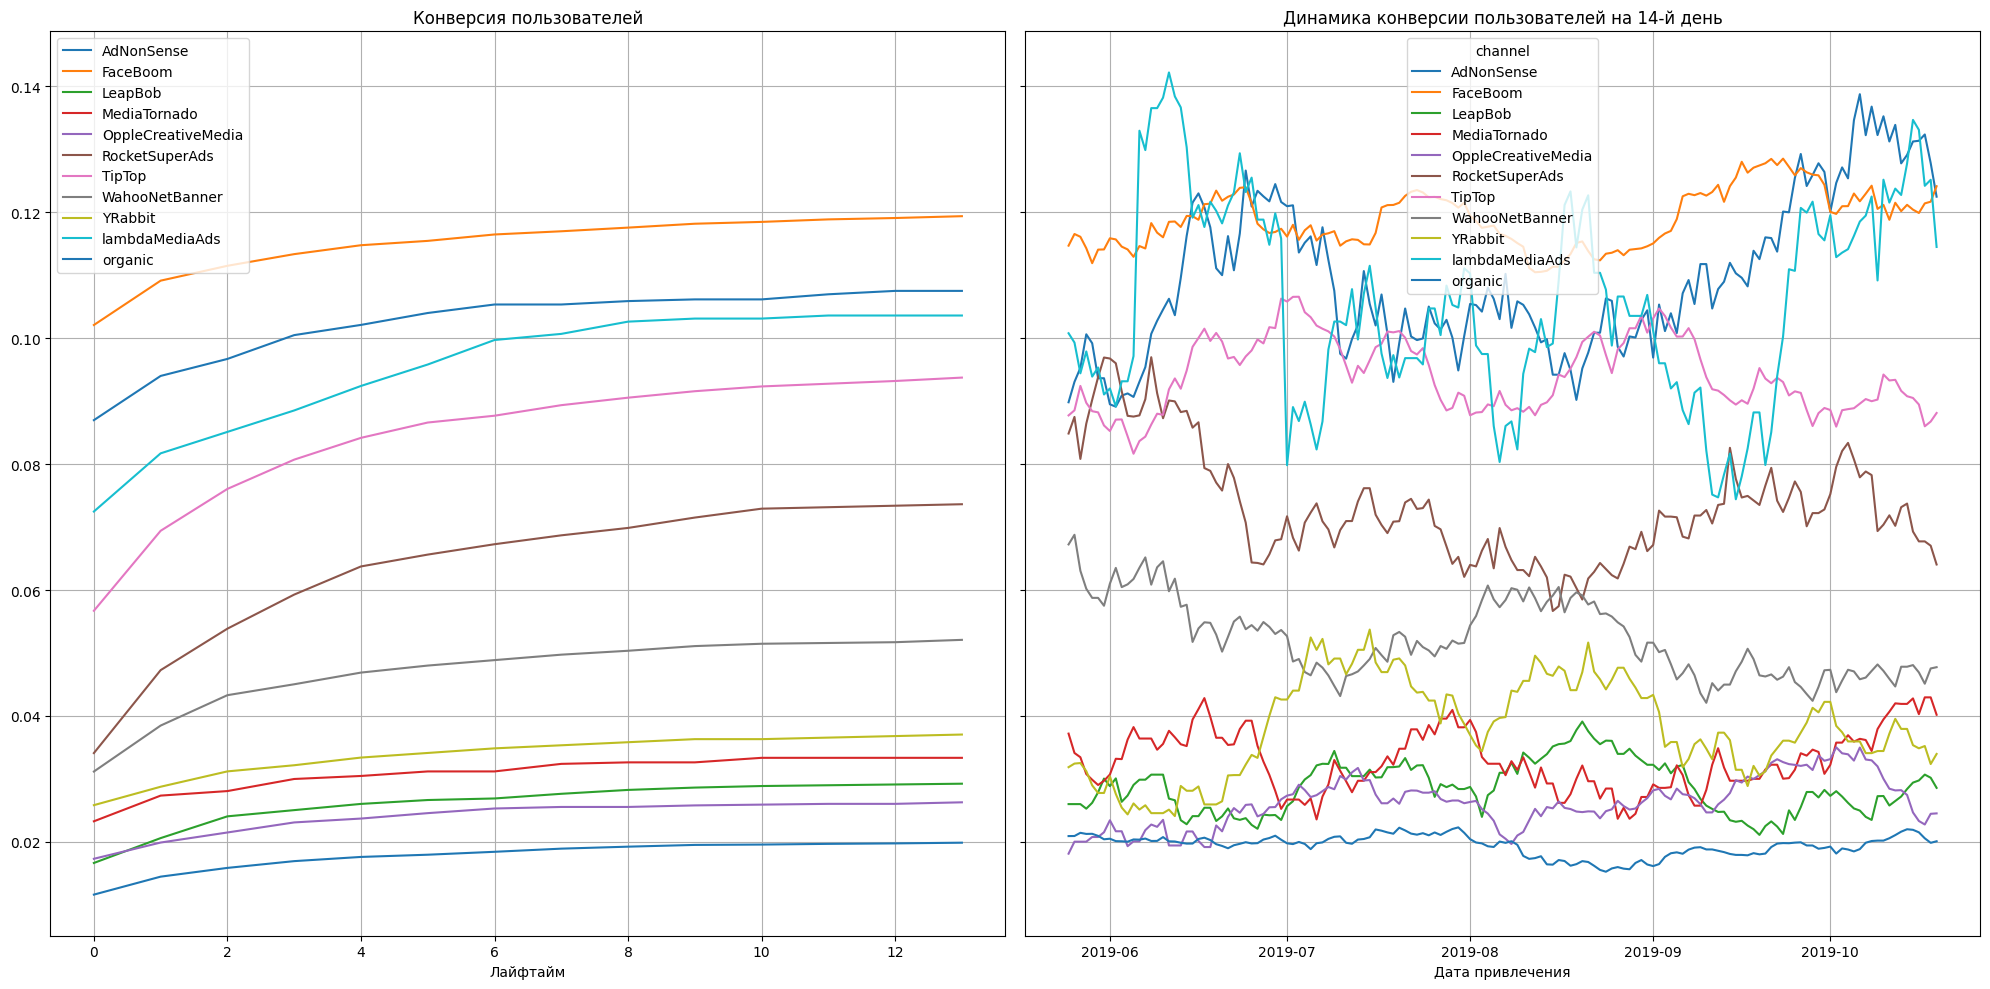

In [27]:
plot_conversion(result_grouped, result_in_time, horizon_days, window=25)

Наибольшая часть клиентов приходит с органической выдачи рекламы, далее идут FaceBoom(27544) и TipTop(18498). Наибольшая конверсия пользователей с FaceBoom - 11,9%.

### Маркетинг

- Посчитайте общую сумму расходов на маркетинг.
- Выясните, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
- Постройте визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику. Постарайтесь отразить это на одном графике.
- Узнайте, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. Используйте профили пользователей.

Напишите промежуточные выводы.

#### Сумма расходов:

In [28]:
display( 'Сумма всех расходов:', costs['costs'].sum().round(2))

'Сумма всех расходов:'

105497.3

In [29]:
costs_sources = costs.groupby('channel')['costs'].sum().reset_index().sort_values(by = 'costs', ascending = False)
costs_sources

channel     costs
6              TipTop  54751.30
1            FaceBoom  32445.60
7      WahooNetBanner   5151.00
0          AdNonSense   3911.25
4  OppleCreativeMedia   2151.25
5      RocketSuperAds   1833.00
2             LeapBob   1797.60
9      lambdaMediaAds   1557.60
3        MediaTornado    954.48
8             YRabbit    944.22

In [30]:
costs_sources['fraction']=(costs_sources['costs'] / costs['costs'].sum() * 100).round(1)
costs_sources

channel     costs  fraction
6              TipTop  54751.30      51.9
1            FaceBoom  32445.60      30.8
7      WahooNetBanner   5151.00       4.9
0          AdNonSense   3911.25       3.7
4  OppleCreativeMedia   2151.25       2.0
5      RocketSuperAds   1833.00       1.7
2             LeapBob   1797.60       1.7
9      lambdaMediaAds   1557.60       1.5
3        MediaTornado    954.48       0.9
8             YRabbit    944.22       0.9

TipTop тратит на рекламу огромное количество денег - больше половины всех расходов, второй по затратности FaceBoom - 30,8%.

#### Расходы по дням/месяцам.

In [31]:
costs['dt'] = pd.to_datetime(costs['dt'])
costs['week']= costs['dt'].dt.isocalendar().week
costs['month'] = costs['dt'].dt.month

In [32]:
costs.head(5)

dt   channel  costs  week  month
0 2019-05-01  FaceBoom  113.3    18      5
1 2019-05-02  FaceBoom   78.1    18      5
2 2019-05-03  FaceBoom   85.8    18      5
3 2019-05-04  FaceBoom  136.4    18      5
4 2019-05-05  FaceBoom  122.1    18      5

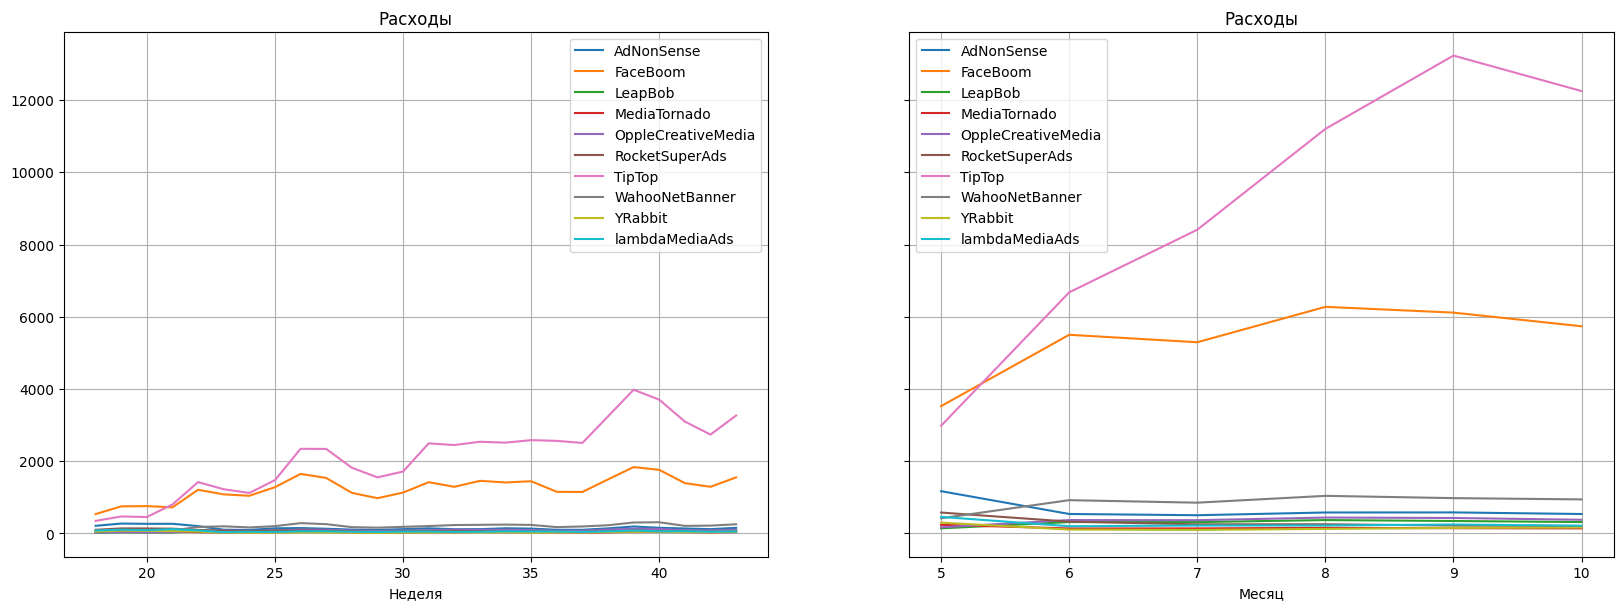

In [33]:
plt.figure(figsize=(20, 15))
ax1 = plt.subplot(2, 2, 1)
costs.pivot_table(index='week', columns = 'channel', values='costs', aggfunc='sum').plot(grid=True, ax=ax1)
plt.legend()
plt.xlabel('Неделя')
plt.title('Расходы')

ax2 = plt.subplot(2, 2, 2, sharey=ax1)
costs.pivot_table(index='month', columns = 'channel', values='costs', aggfunc='sum').plot(grid=True, ax=ax2)
plt.legend()
plt.xlabel('Месяц')
plt.title('Расходы')

plt.show()

Выделяются 2 компании: TipTop и FaceBoom, бюджеты на эти РК сильно больше других, маркетингу стоит пересмотреть стратегию, возможно вливается слишком много денег в продвижение.

#### Стоимость привлечения нового пользователя.

In [34]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=['channel'])

In [35]:
costs_cac = roi_grouped.pivot_table(index='channel', values='cac')
costs_cac.sort_values(by ='cac', ascending = False)

cac
channel                     
TipTop              2.757774
FaceBoom            1.113419
AdNonSense          1.008023
lambdaMediaAds      0.727237
WahooNetBanner      0.601856
RocketSuperAds      0.417431
OppleCreativeMedia  0.249908
MediaTornado        0.219035
YRabbit             0.217087
LeapBob             0.210000

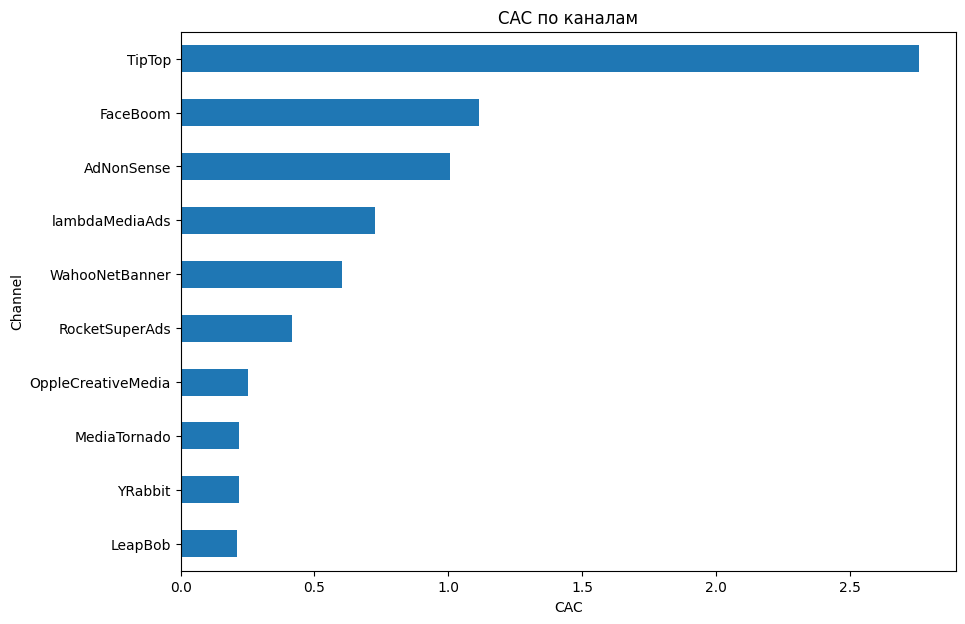

In [36]:
costs_cac.sort_values(by = 'cac', ascending=True).plot(kind = 'barh', figsize =[10,7], legend = False)
plt.title('CAC по каналам')
plt.xlabel('CAC')
plt.ylabel('Channel')
plt.show()

Ожидаемо, что с такими расходами TipTop будет иметь высокий CAC в 2.7, далее идут FaceBoom (1,11) и AdNonSense(1), остальные каналы имеют сильно меньшие показатели.

В итоге имеем 3 очень дорогие компании TipTop, FaceBoom и AdNoneSense, они имеют очень большие расходы по рекламе, и следовательно CAC тоже довольно высокий, что обычно не очень хорошо(зависит от маржинальности продукта, который может сильно окупить рекламные расходы).

### Оцените окупаемость рекламы

Используя графики LTV, ROI и CAC, проанализируйте окупаемость рекламы. Считайте, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Необходимость включения в анализ органических пользователей определите самостоятельно.

- Проанализируйте окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проверьте конверсию пользователей и динамику её изменения. То же самое сделайте с удержанием пользователей. Постройте и изучите графики конверсии и удержания.
- Проанализируйте окупаемость рекламы с разбивкой по устройствам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по странам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Ответьте на такие вопросы:
    - Окупается ли реклама, направленная на привлечение пользователей в целом?
    - Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
    - Чем могут быть вызваны проблемы окупаемости?

Напишите вывод, опишите возможные причины обнаруженных проблем и промежуточные рекомендации для рекламного отдела.

#### Общая окупаемость рекламы.

Для корректности расчетов удалим из выборки пользователей который перешли по органической рекламе.

In [37]:
profiles=profiles.query('channel != "organic"')

In [38]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days)

Строим графики

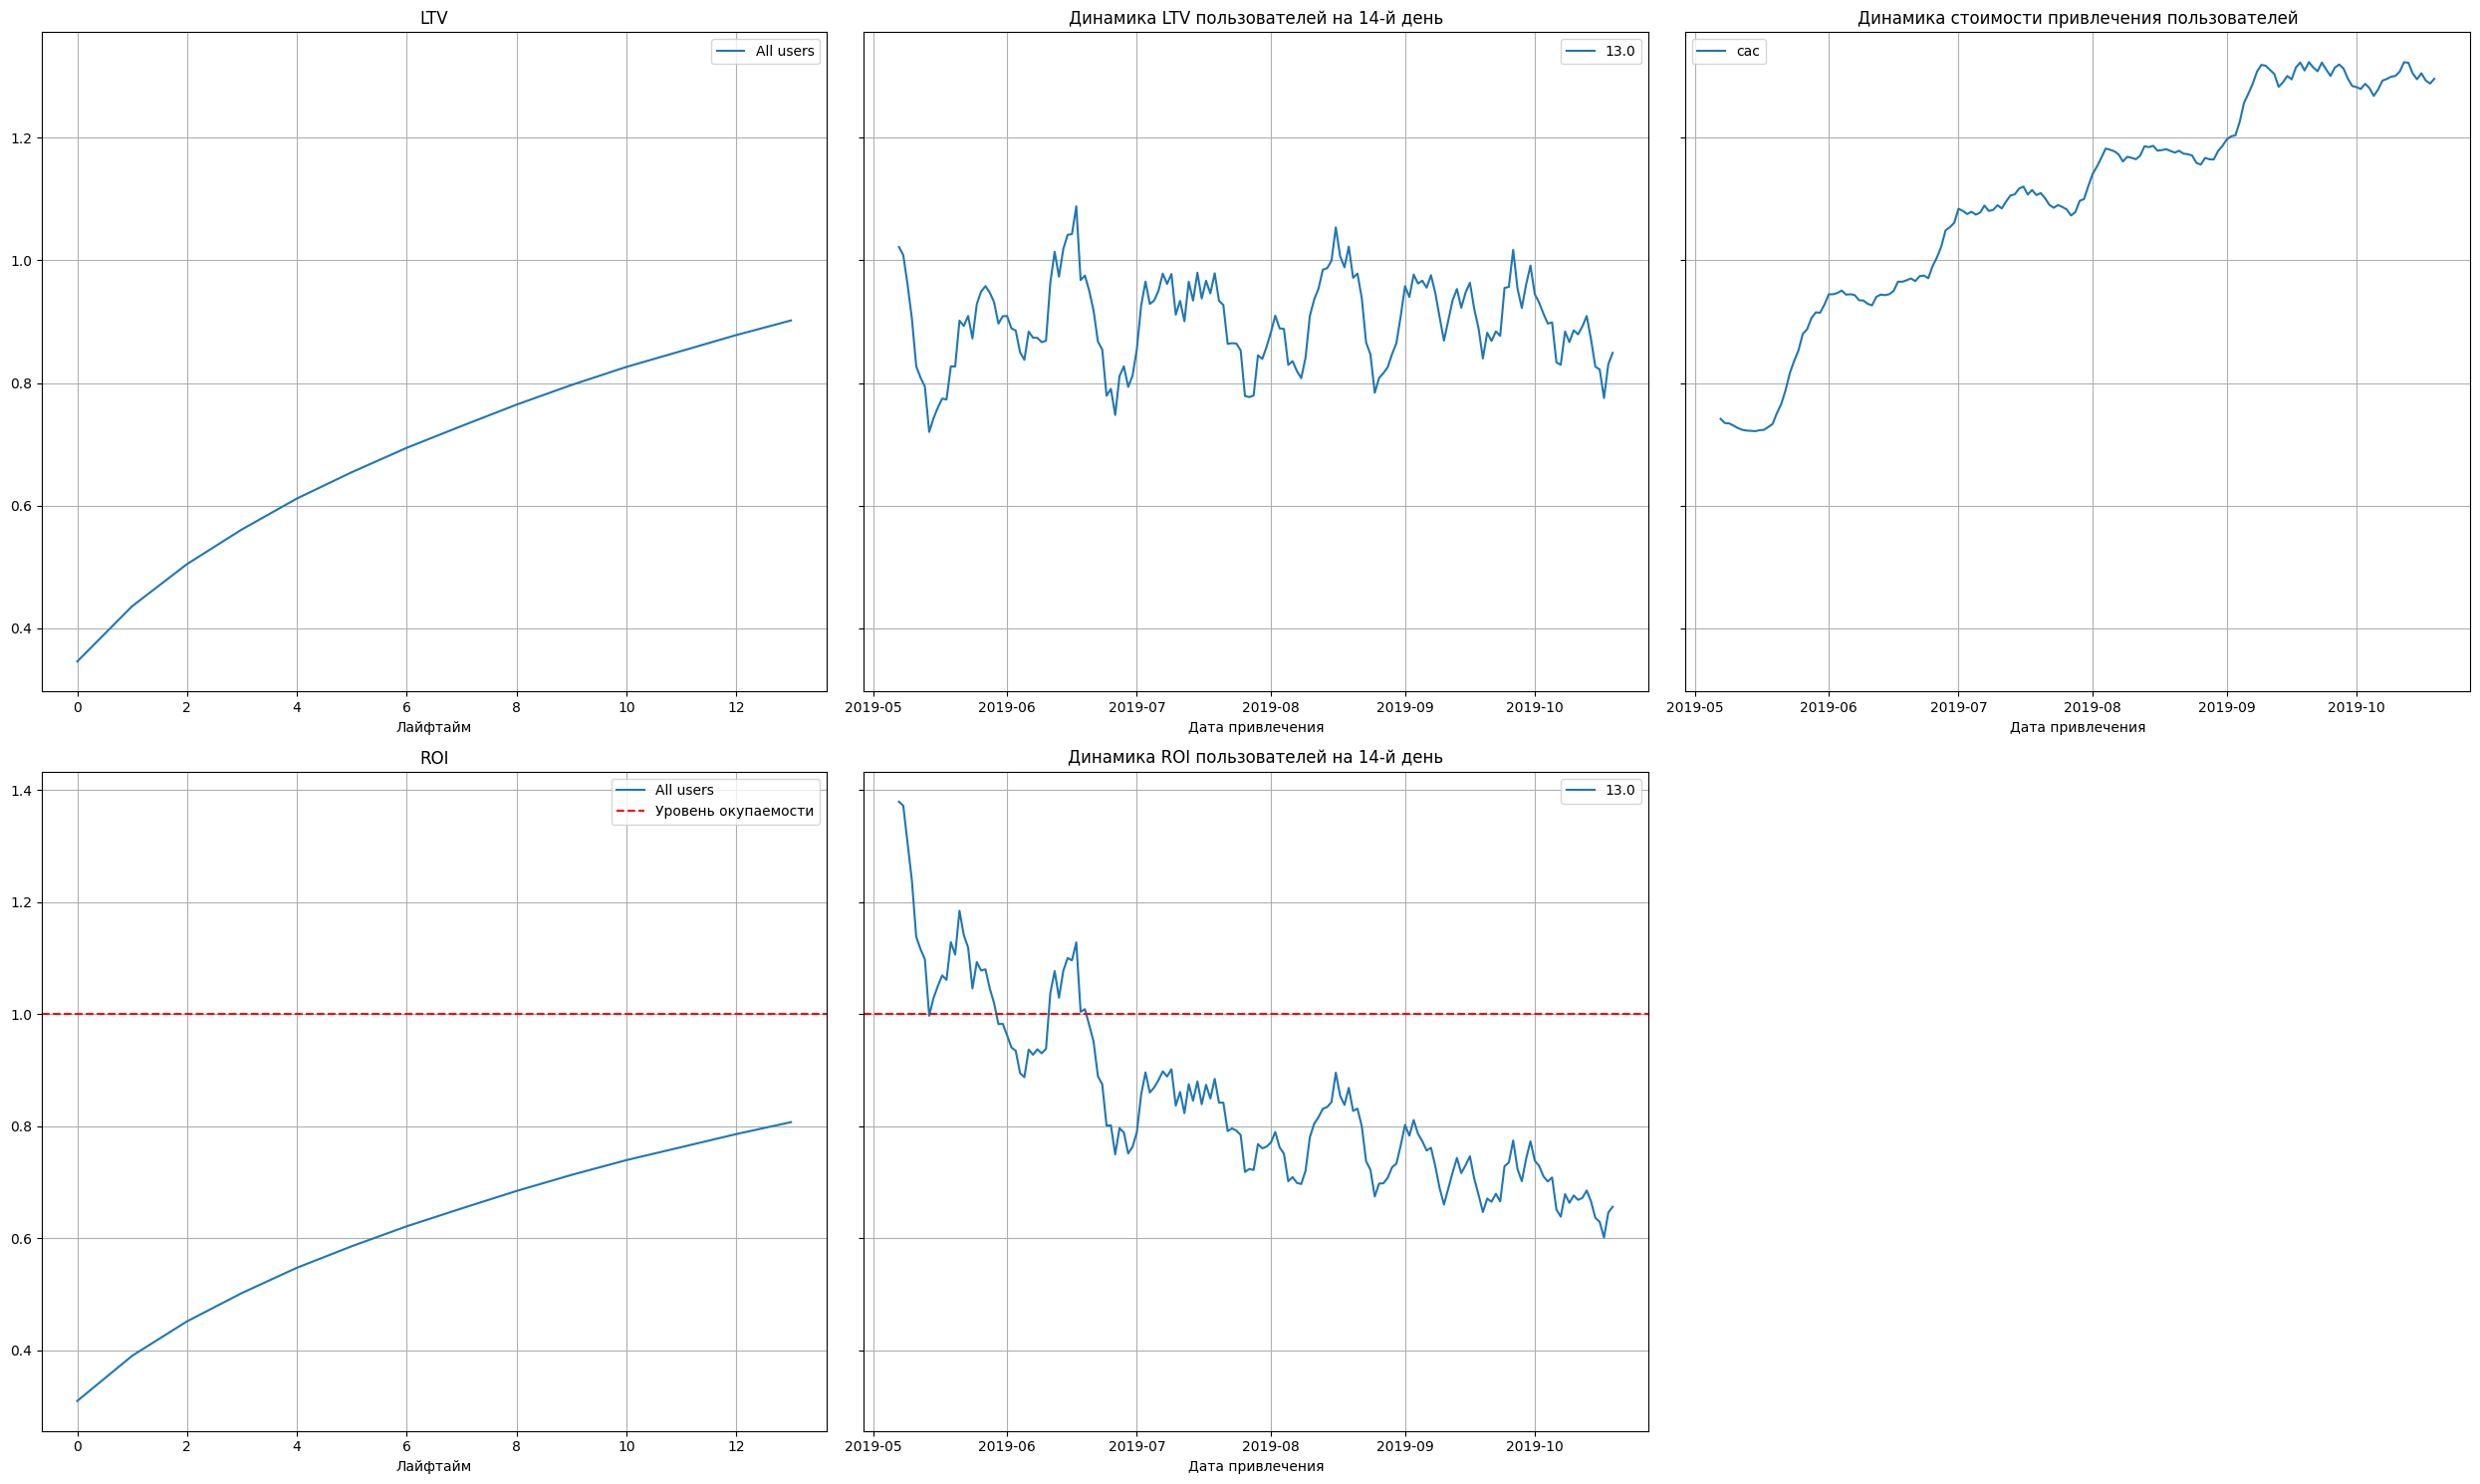

In [39]:
# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

Предварительные Выводы по графикам:
- По общим данным Реклама не окупается
- ROI падает
- CAC сильно повышается
- LTV скачет каждый месяц, но в целом стабильно держится в одном диапазоне

Выглядит плохо, нужно разбираться.

Необходимо провести анализ с разбивкой по странам, устройствам и каналам.

#### Разбивка по странам

In [40]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['region'])

Построим графики.

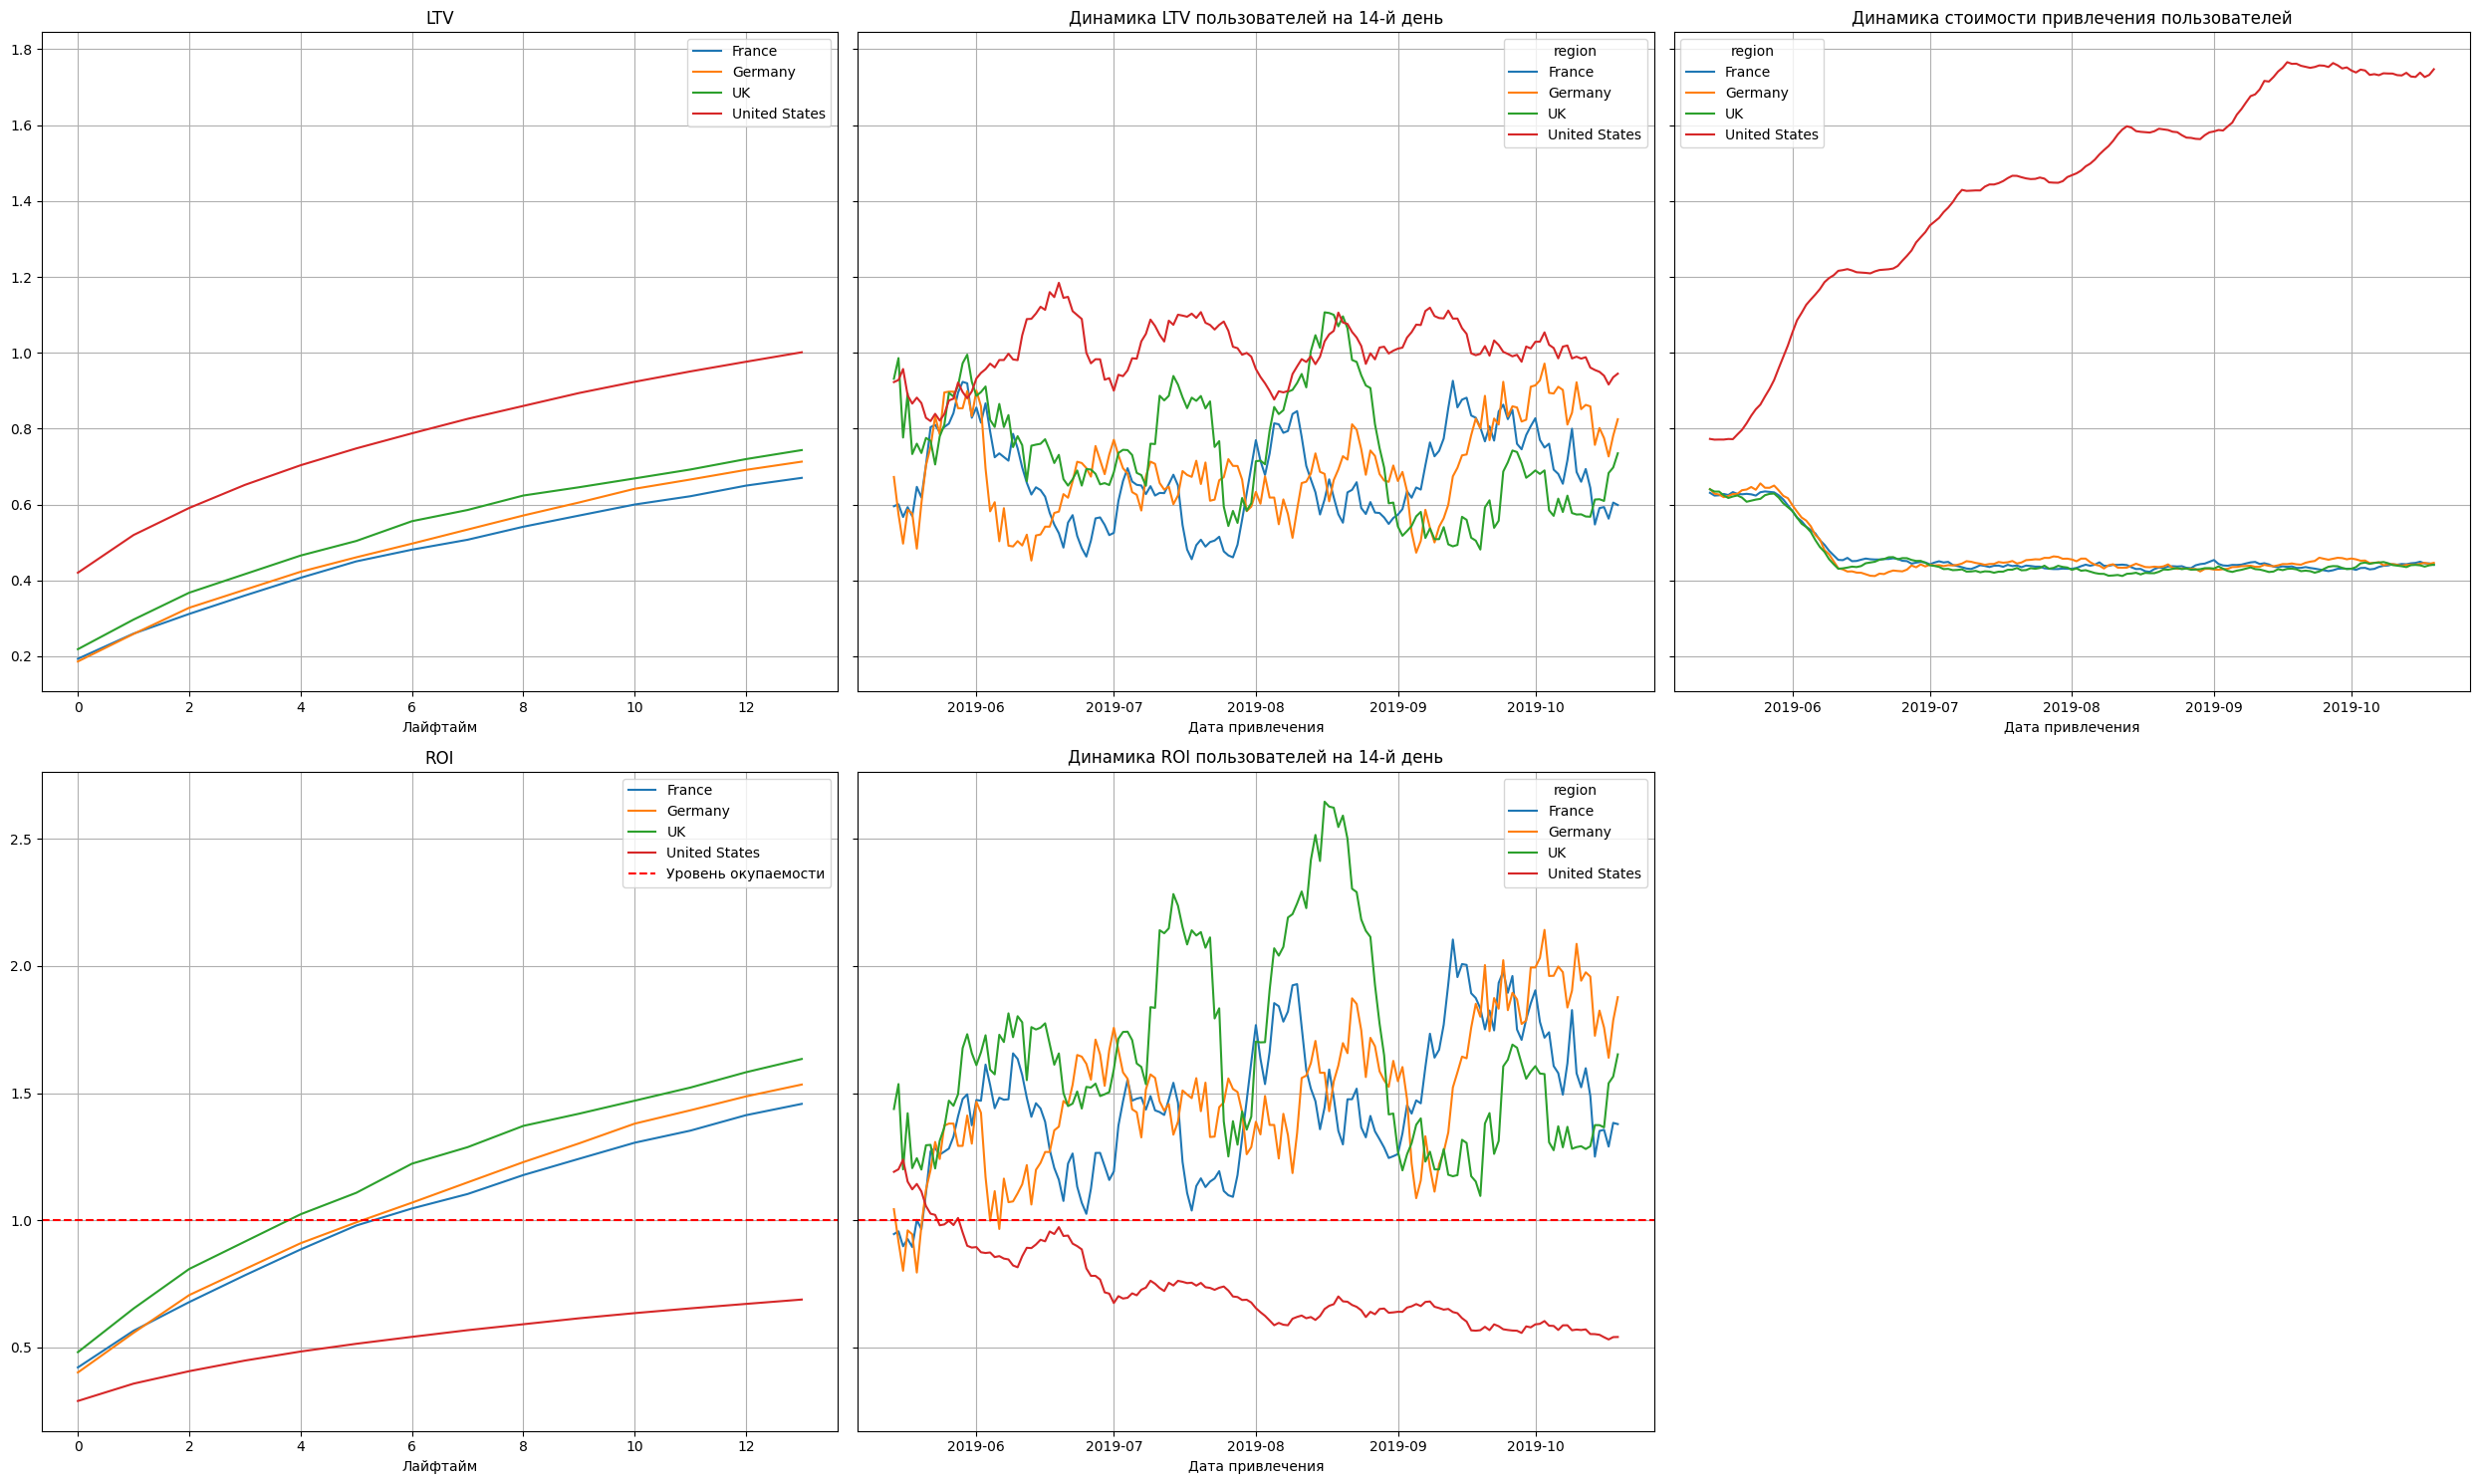

In [41]:
plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14)

Выводы:
- Реклама в США не окупается
- CAC в США очень высок - необходимо пересмотреть бюджеты на РК, в остальных странах все отлично
- LTV во всех странах примерно на одном уровне, однако в США он сильно больше остальных

По данной разбивке, нужно заострить внимание на РК в США, остальные страны имеют хорошие показатели.

Посмотрим конверсию по данной разбивке

In [42]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['region'])

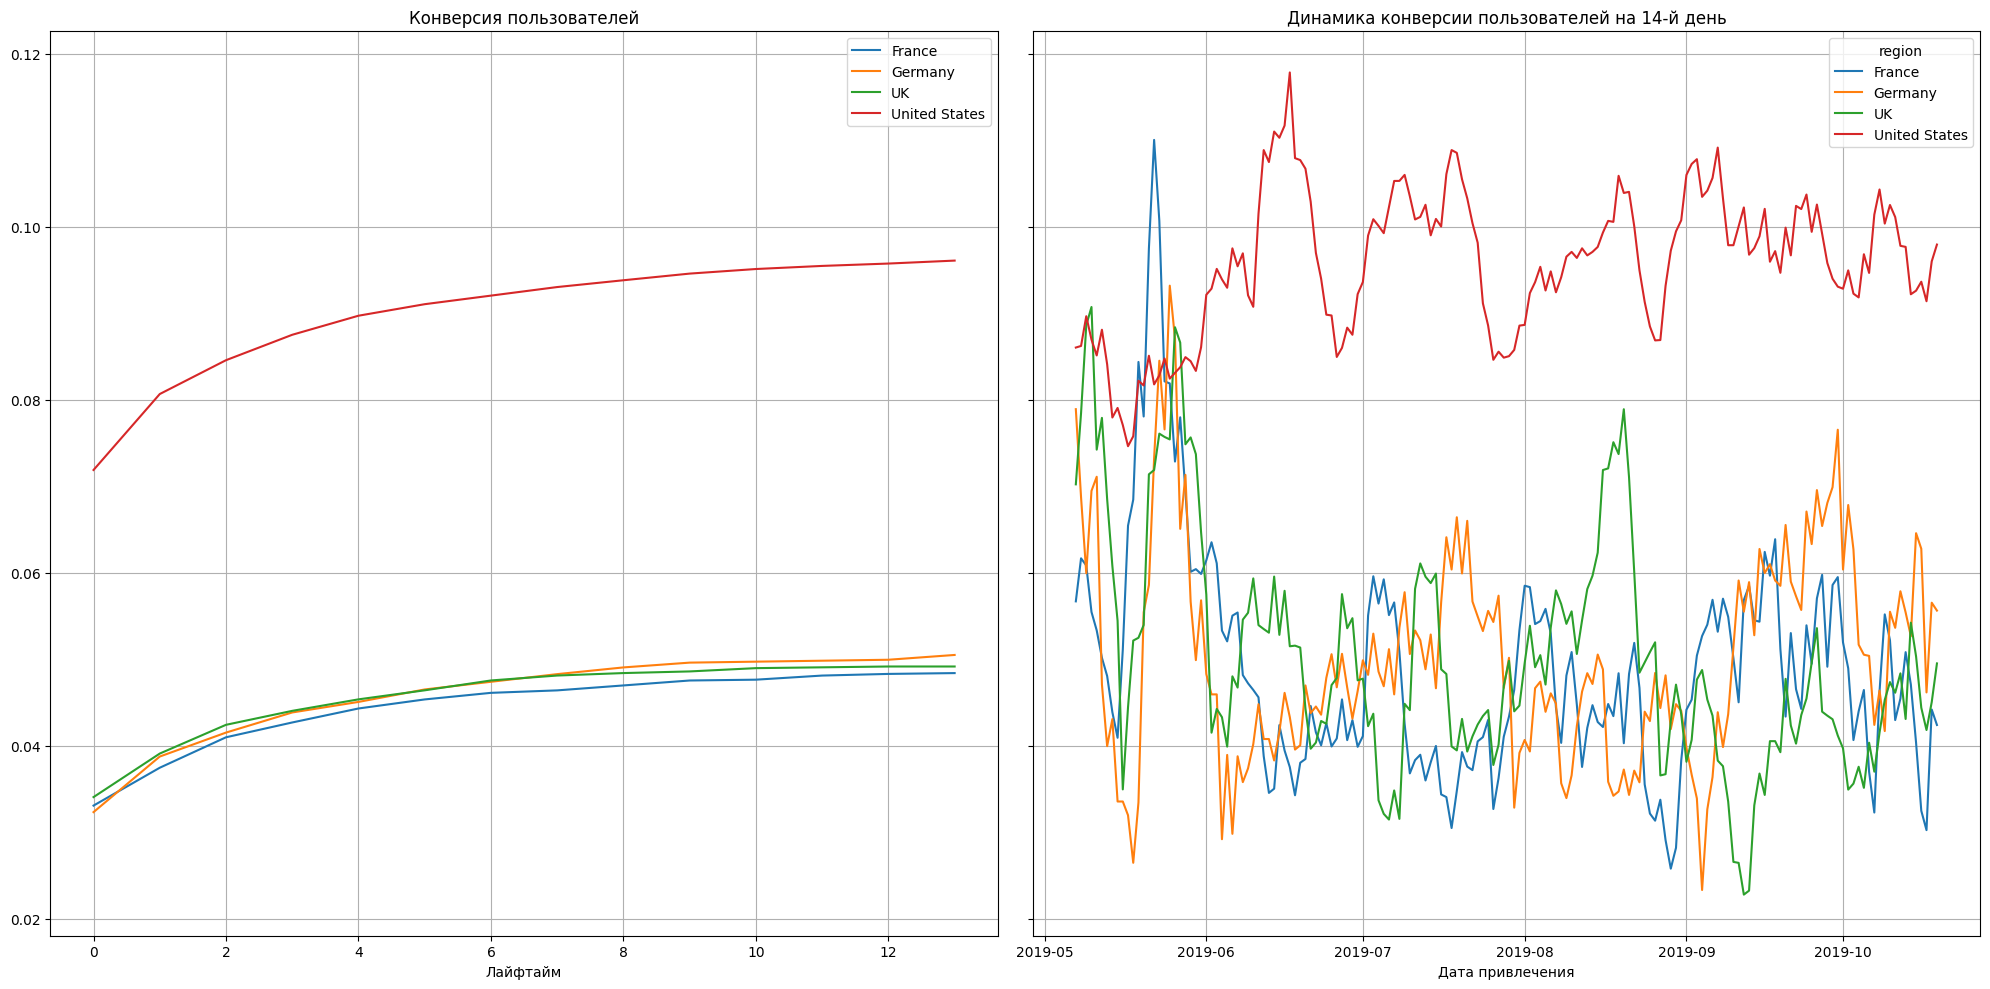

In [43]:
plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Конверсия в США просто прекрасная, по остальным странам явных отклонений нет, все стабильно.

США показывает прекрасные показатели конверсии и LTV, однако РК не окупается.

Расчитаем удержание пользователей

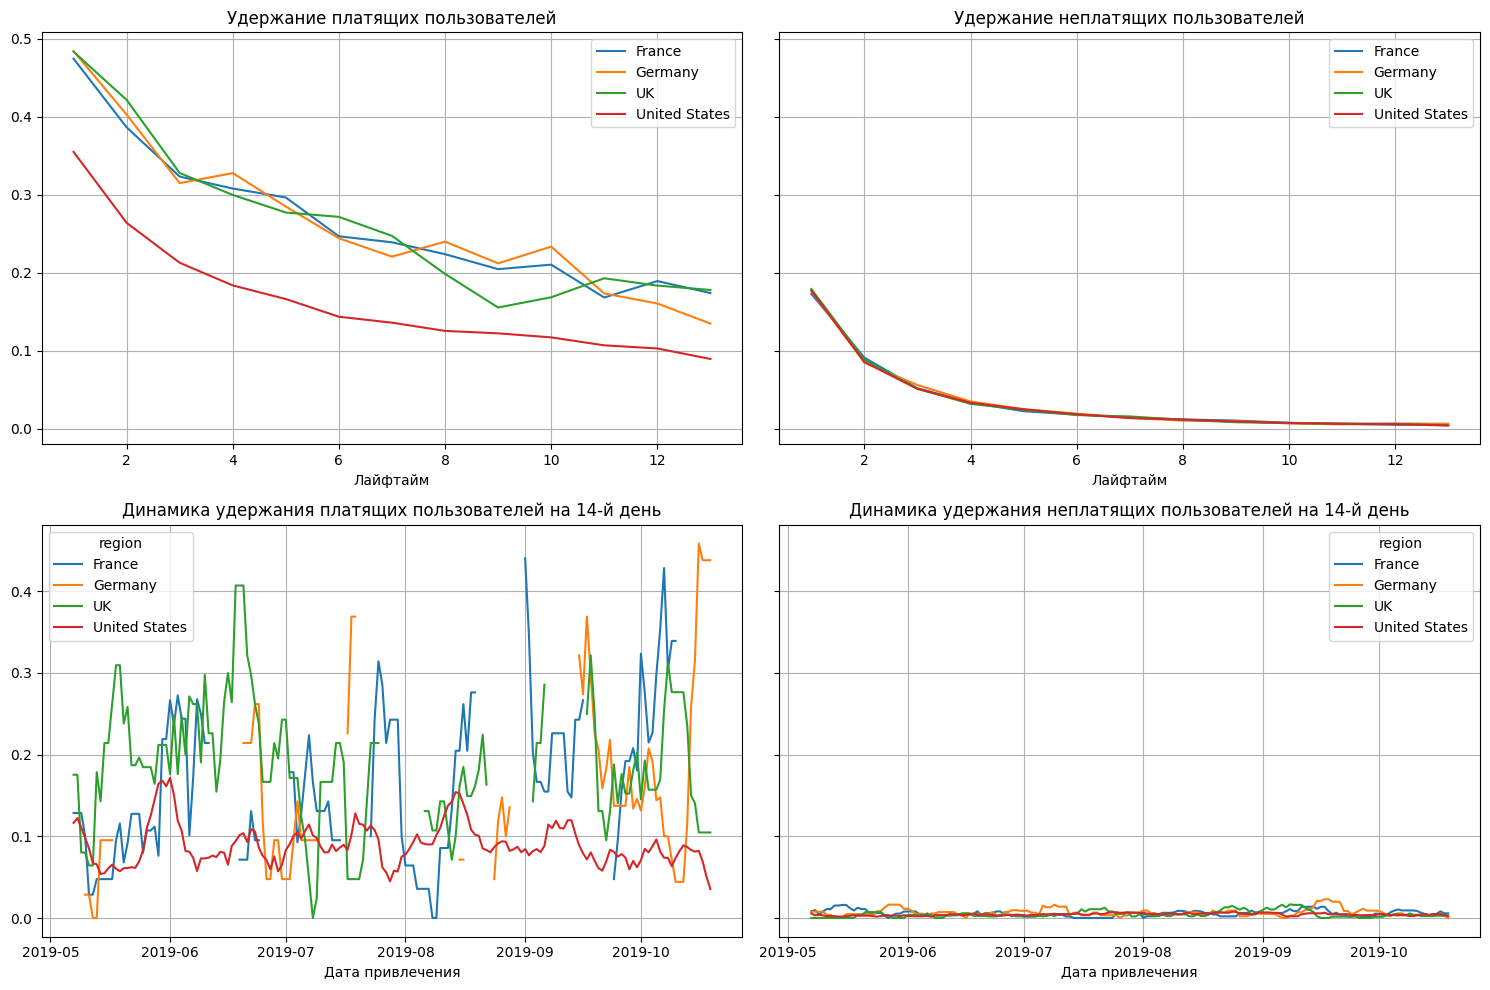

In [44]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['region'])
plot_retention(retention_grouped, retention_history, horizon_days)

In [45]:
retention_grouped

cohort_size    0         1         2         3         4  \
payer region                                                                    
False France                9993  1.0  0.173021  0.091164  0.052036  0.033724   
      Germany               8563  1.0  0.176690  0.084900  0.056172  0.035034   
      UK                   10002  1.0  0.179064  0.088582  0.051390  0.031994   
      United States        52776  1.0  0.177221  0.085626  0.051160  0.033500   
True  France                 523  1.0  0.474187  0.386233  0.323136  0.307839   
      Germany                467  1.0  0.483940  0.402570  0.314775  0.327623   
      UK                     534  1.0  0.483146  0.421348  0.327715  0.299625   
      United States         5786  1.0  0.354822  0.263913  0.212755  0.183719   

                            5         6         7         8         9  \
payer region                                                            
False France         0.022616  0.018213  0.014610  0.012108  0.010607   
      Germany        0.025225  0.019503  0.014014  0.010510  0.009926   
      UK             0.024595  0.017696  0.015897  0.011598  0.008498   
      United States  0.025030  0.018777  0.013813  0.011880  0.009474   
True  France         0.296367  0.246654  0.239006  0.223709  0.204589   
      Germany        0.284797  0.244111  0.220557  0.239829  0.211991   
      UK             0.277154  0.271536  0.247191  0.198502  0.155431   
      United States  0.166263  0.143623  0.136018  0.125475  0.122364   

                           10        11        12        13  
payer region                                                 
False France         0.007805  0.006304  0.005304  0.005504  
      Germany        0.007007  0.005722  0.006890  0.006540  
      UK             0.007299  0.006899  0.006399  0.004499  
      United States  0.007541  0.006423  0.005931  0.004301  
True  France         0.210325  0.168260  0.189293  0.173996  
      Germany        0.233405  0.173448  0.160600  0.134904  
      UK             0.168539  0.192884  0.183521  0.177903  
      United States  0.117179  0.106982  0.103007  0.089526

А вот и проблема -удержание пользователей, к 14 дню показатель у США в 1.5-2 раза меньше остальных стран. Маркетингу стоит обратить на это внимание.

#### Разбивка по устройствам

In [46]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['device'])

Графики

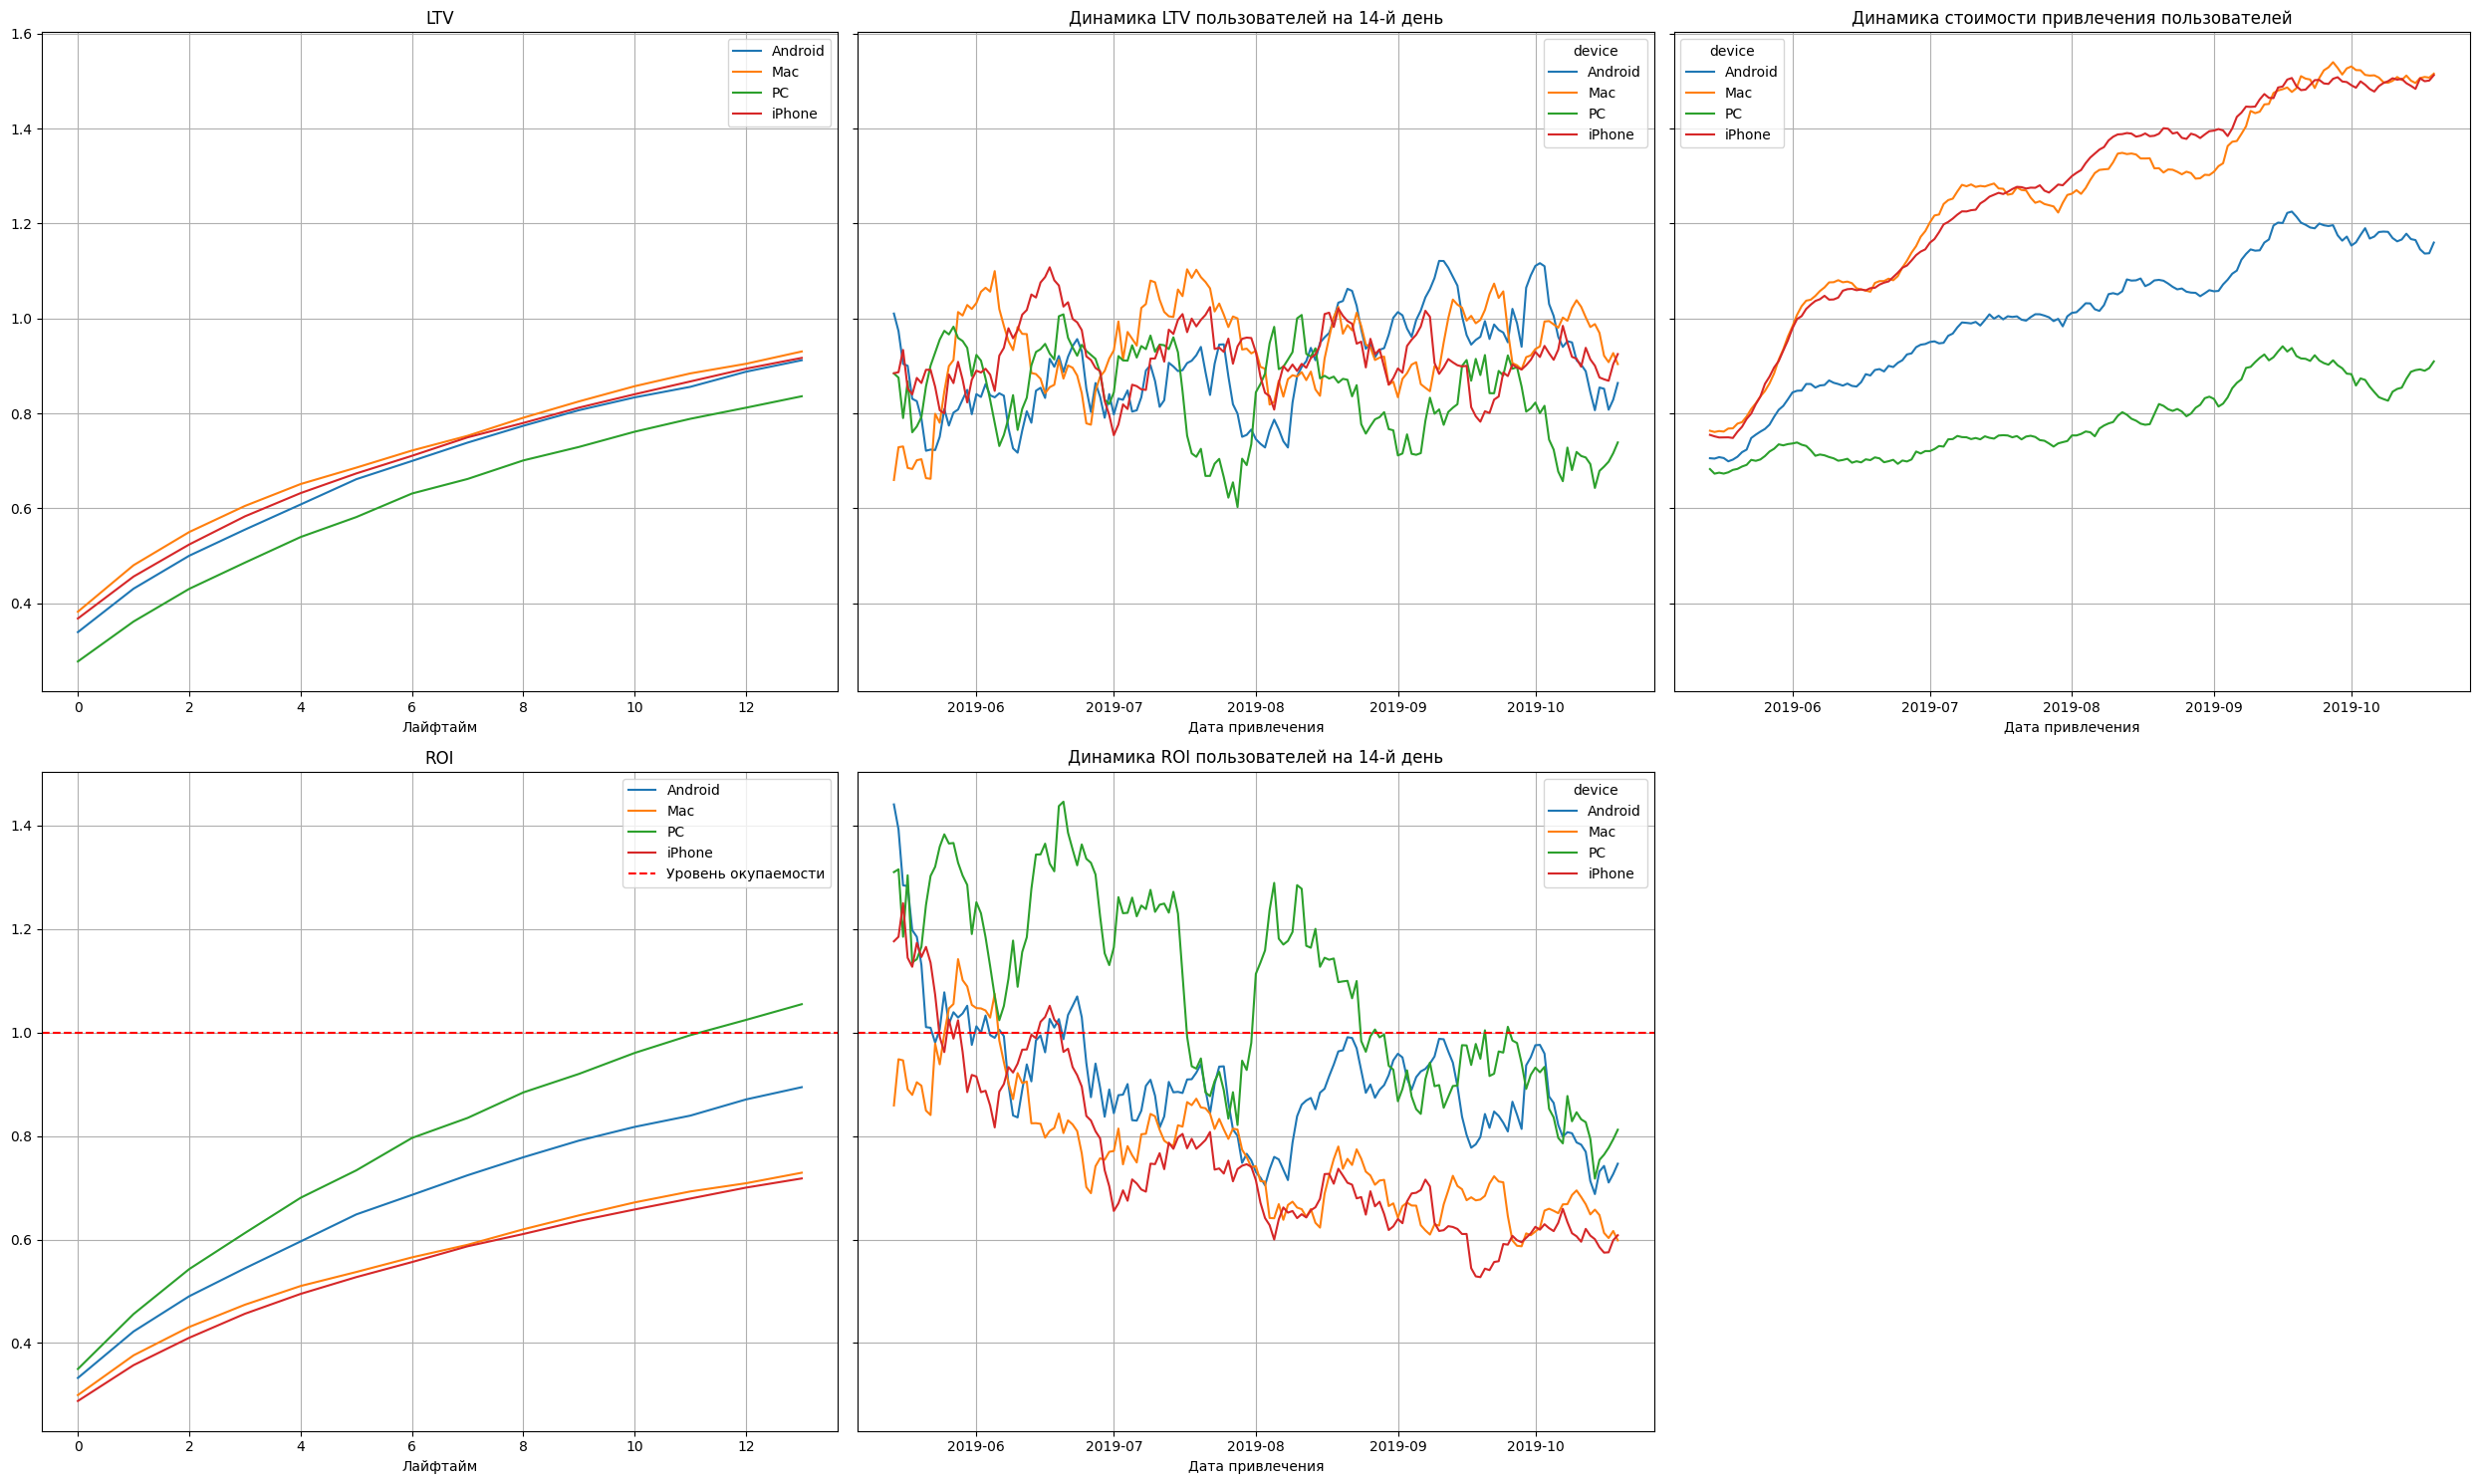

In [47]:
plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14)

Выводы:
- Реклама не окупается на всех устройствах, к концу 2й недели PC смог преодолеть границу, но все равно показатели низкие
- CAC постепенно растет у всех пользователей, что не очень хорошо
- LTV стабилен, у пользователей iPhone и MAC довольно низкий

Расчитаем конверсию по разбивке

In [48]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['device'])

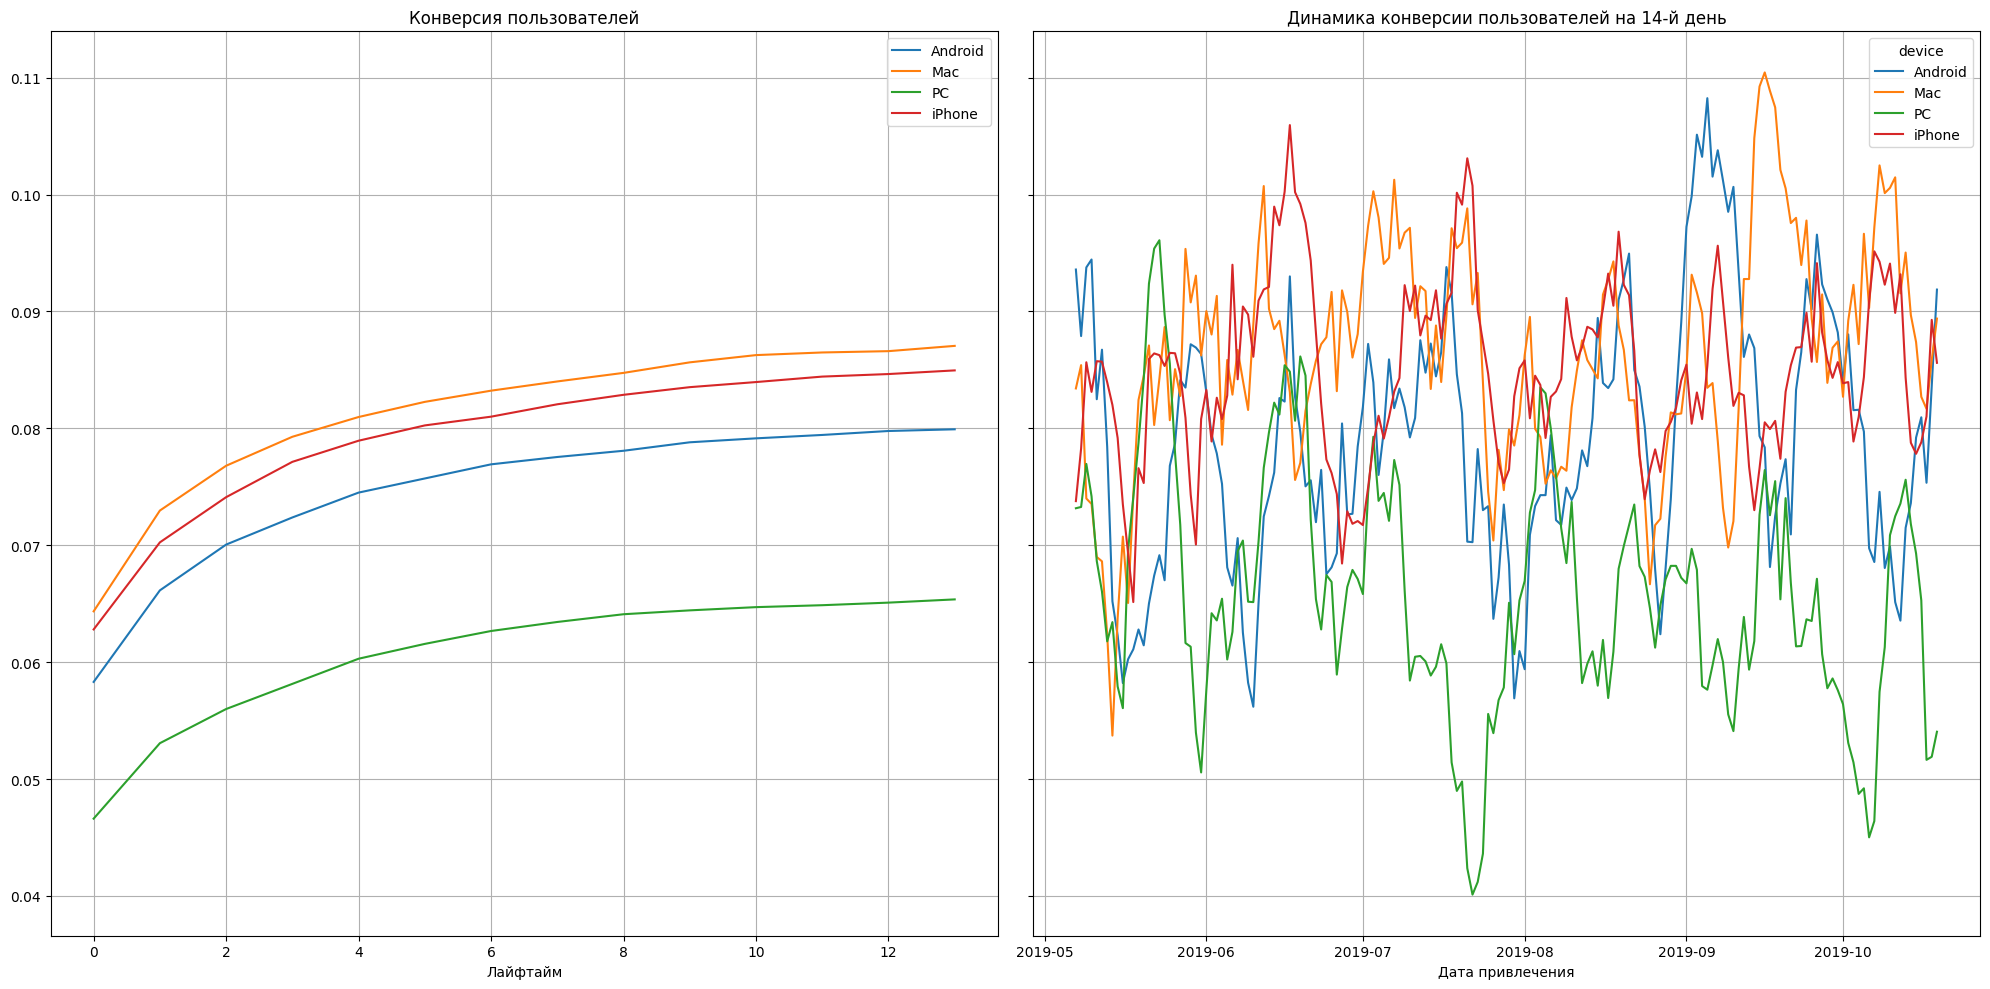

In [49]:
plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Конверсия с ПК самая низкая, однако только эта РК окупается, нужно проблему дальше.

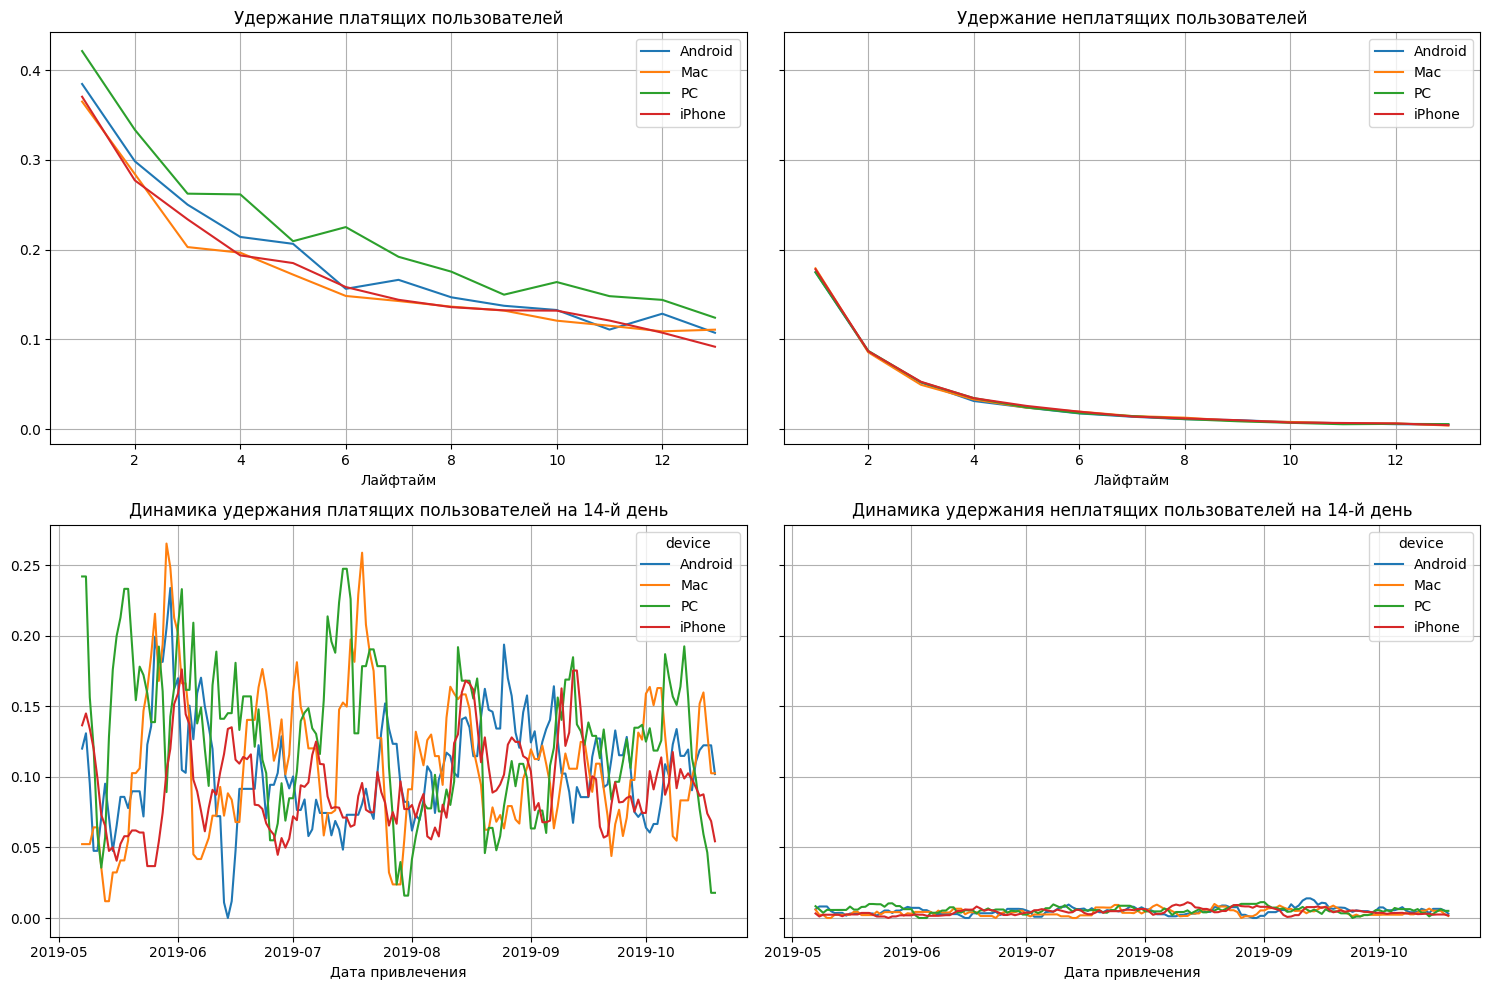

In [50]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['device'])
plot_retention(retention_grouped, retention_history, horizon_days)

Удержание по всем устройствам сравнительно одинаковое, явных отстающих нет.

#### Разбивка по каналам

In [51]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['channel'])

Графики

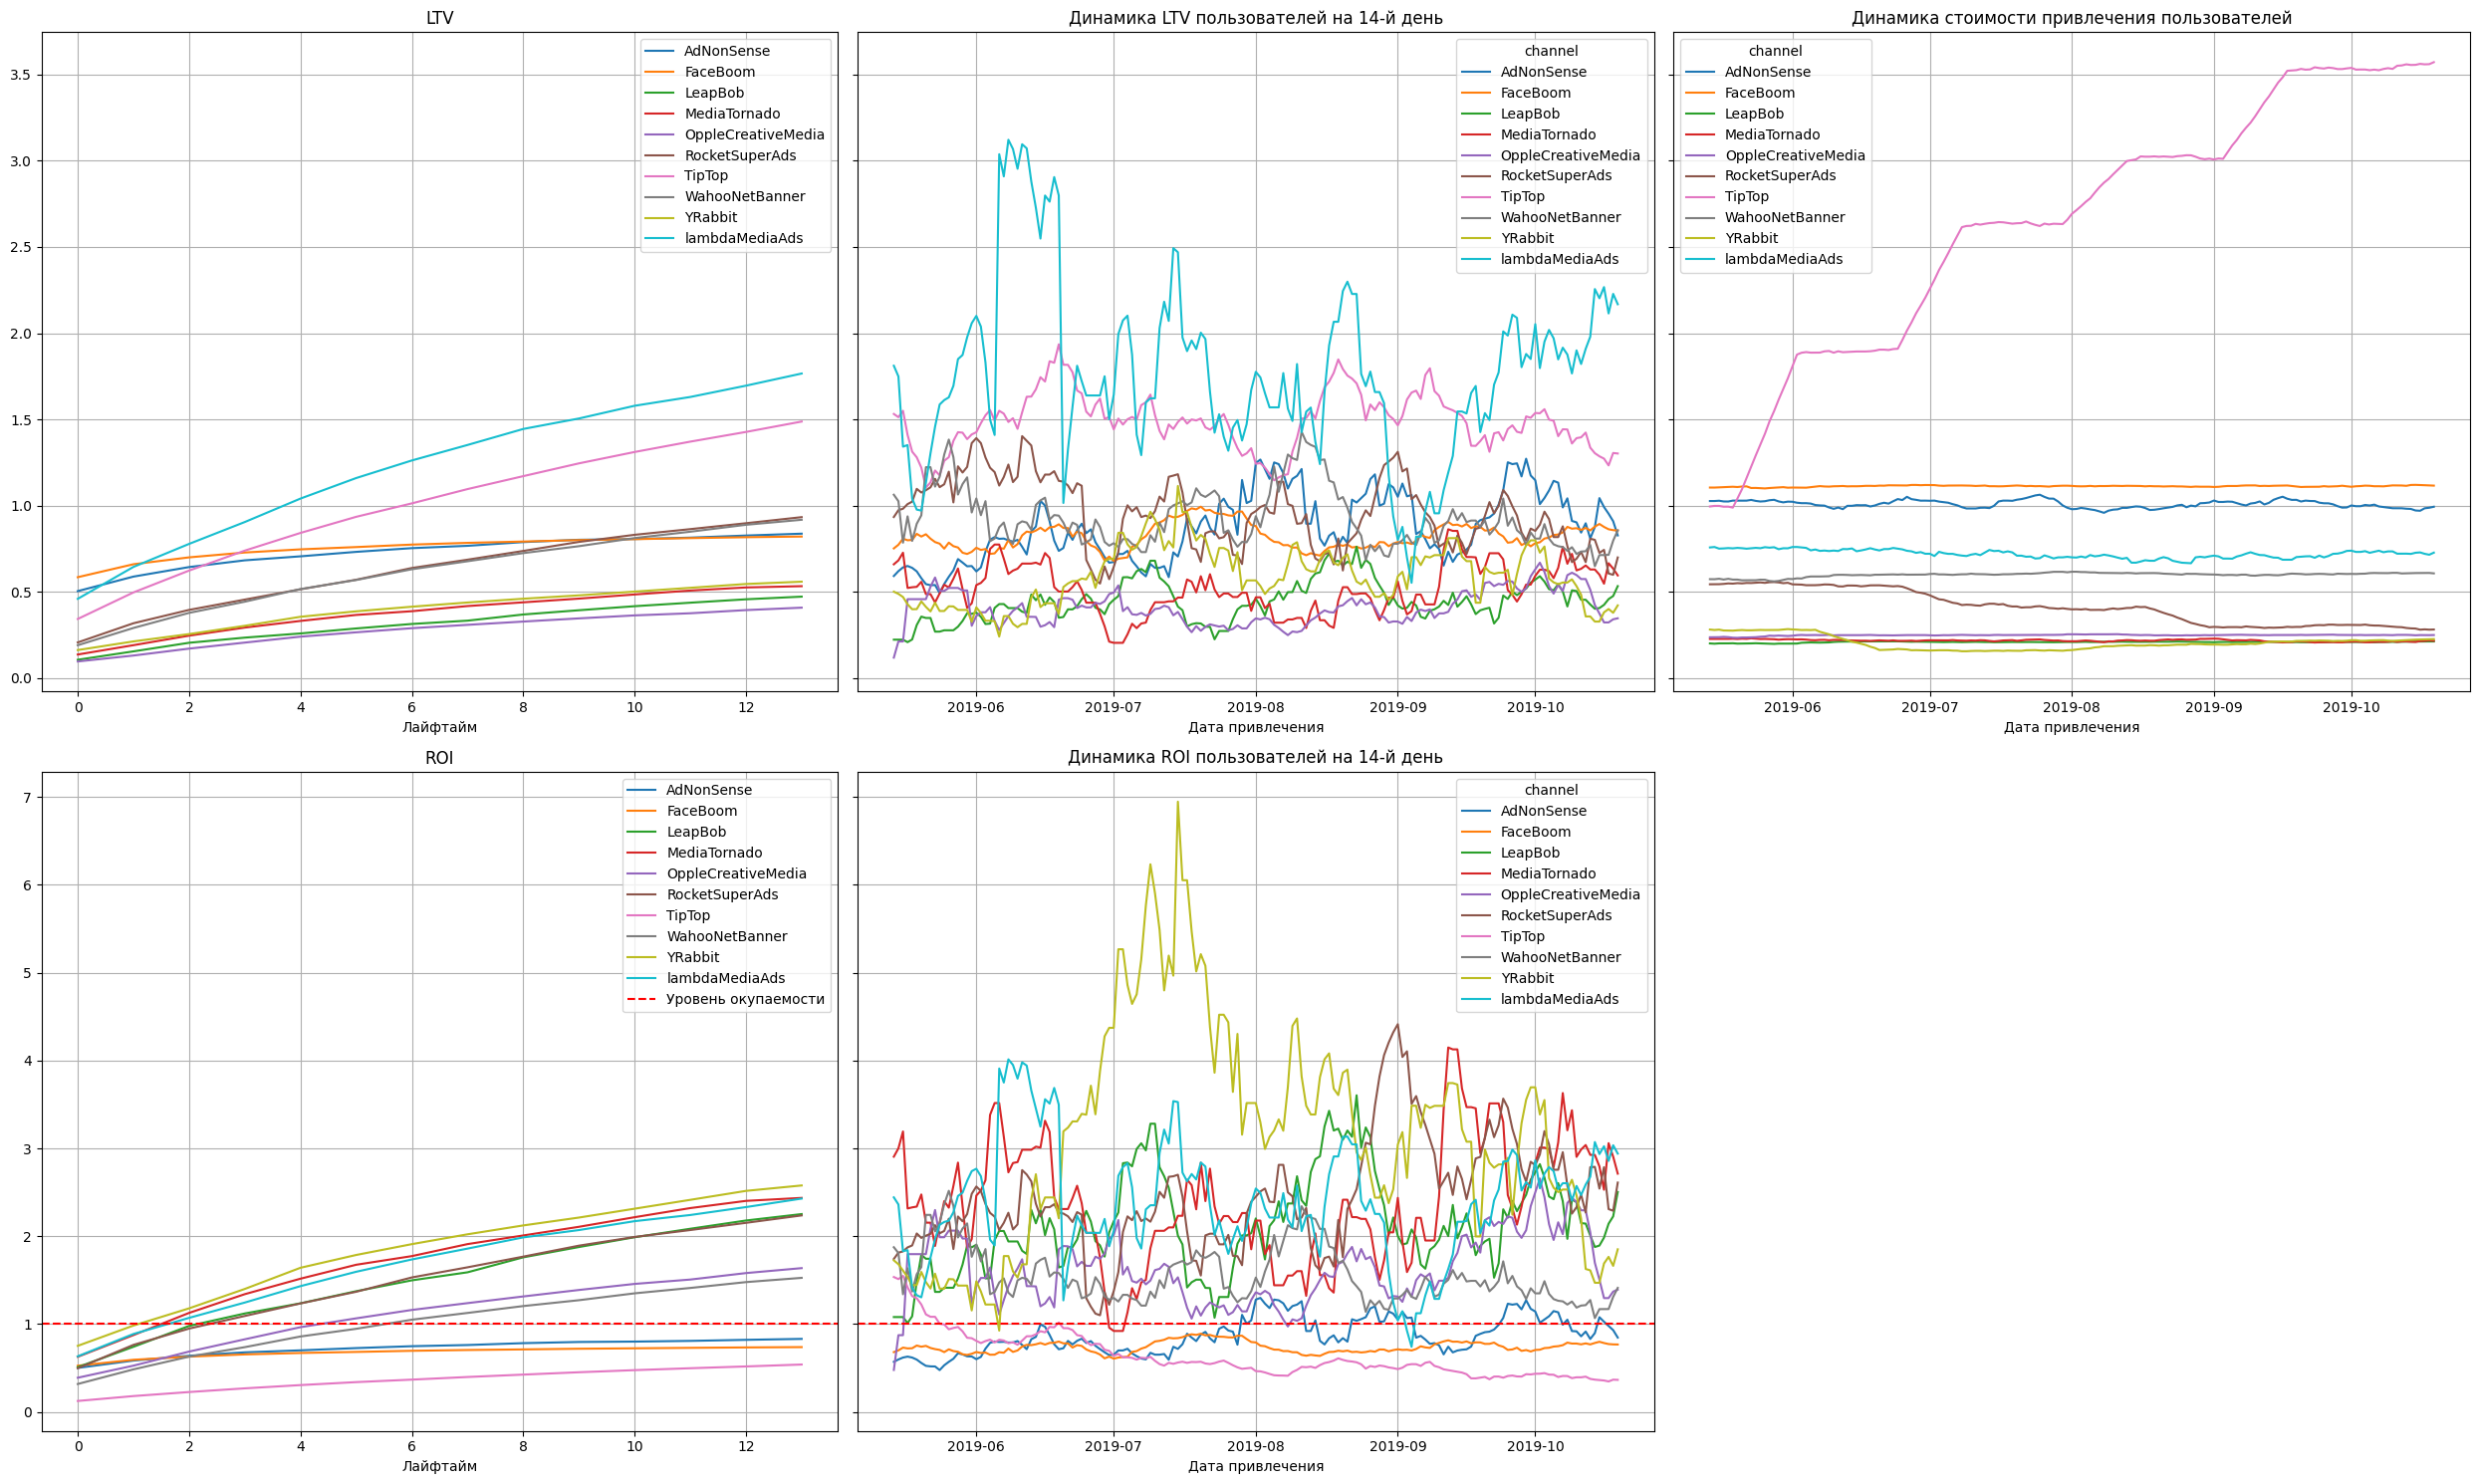

In [52]:
plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14)

Выводы
- Не окупается реклама у: TipTop, FaceBoom, AdNoneSense.
- LTV достаточно низкий у всех компаний, кроме LambdaMediaArts и TipTop
- CAC канала TipTop улетел в небеса, в предыдущих пунктах мы наблюдали подобное - проблемы в бюджете на РК, остальные компании - стабильно

Конверсия

In [53]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['channel'])

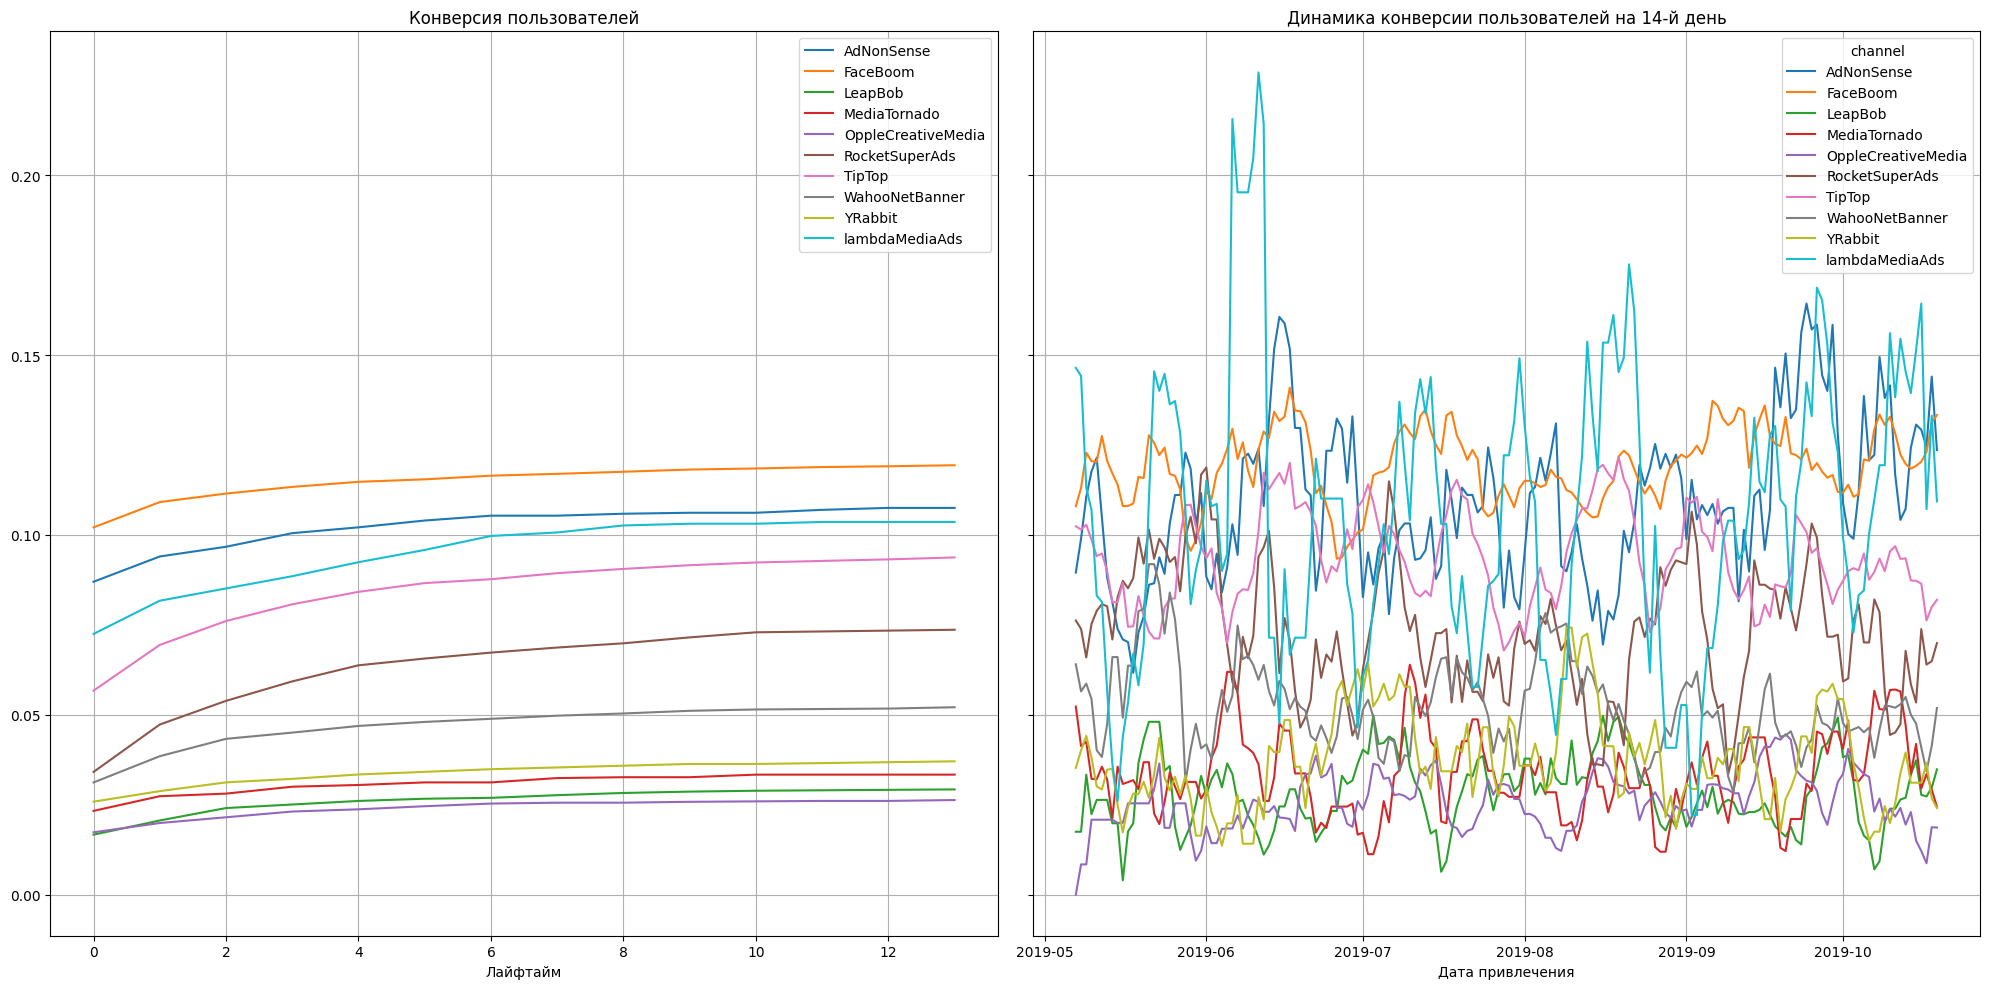

In [54]:
plot_conversion(conversion_grouped, conversion_history, horizon_days) 

У компаний которые не окупаются довольно высокая конверсия, что странно, знаит дело в другом.

Удержание

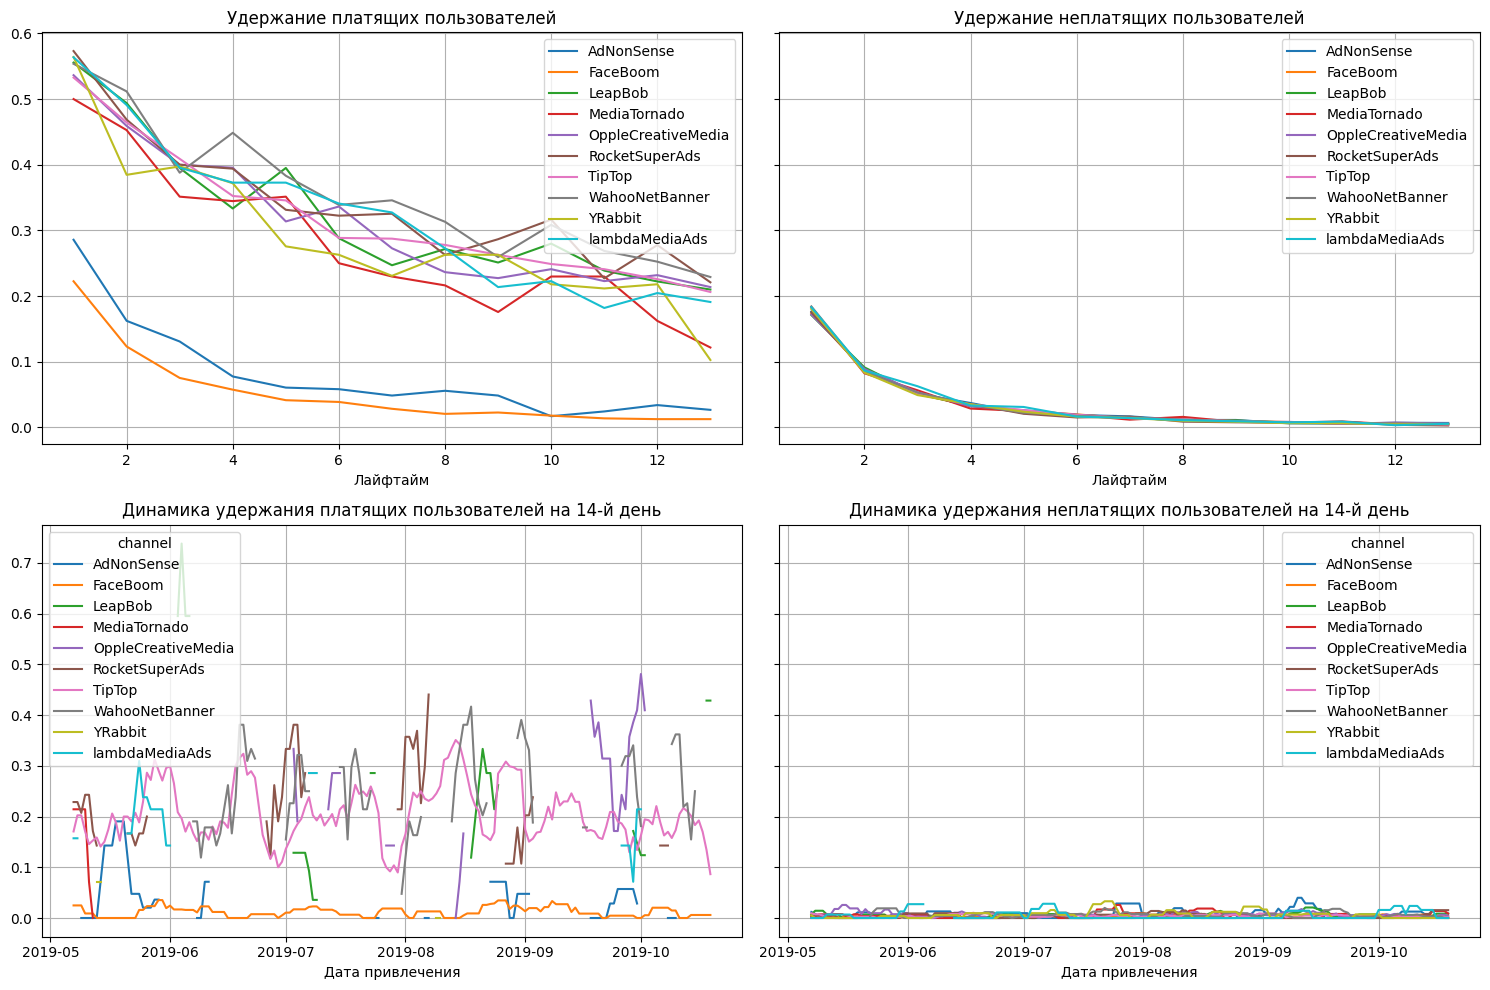

In [55]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['channel'])
plot_retention(retention_grouped, retention_history, horizon_days)

Удержание у FaceBoom и AdNoneSense очень низкое.

### Напишите выводы

- Выделите причины неэффективности привлечения пользователей.
- Сформулируйте рекомендации для отдела маркетинга.

**Общие выводы по анализу:**

В хоже анализа были выявлены следующие проблемы:

- Реклама в США - конверсия и LTV очень хорошие, проблема в удержании и стоимости привлечения пользователей
- Реклама на платформах - не окупается почти везде, конверсии низкие, CAC сильно растет
- Реклама по каналам - TipTop, FaceBoom, AdNoneSense дорогие и не эффективные РК, имеют низкий уровень удержания и высокий CAC, у TipTop особенно. Однако у этих компаний самые высокии конверсии.
- Стоит усилить РК на PC - единственная РК которая окупается, однако у нее низкая конверсия, нужно укрепить позиции
- Возможно стоить пустить больше трафика в другие страны и порабоать с пользователями, тк доля платящих не очень высокая.
- Также не нужно исключать тот момент, что органическая реклама может перекрывать платную, но это очень сложно проверить

Стоит обратить внимание на рекламу в США на всех платформах, пересмотреть бюджеты и порабоать над удержанием пользователей, возможно запустить акции или персонализированные предложения.
Также обратить внимание на самые дорогие РК, пересмотреть их стратегии.